# Using Continual Learning for Traffic State Reconstruction
## Intro
The traffic recostruction is a difficult problem especially when the data is not available on a constant and observed basis. 

In order to reconstruct the actual state given the previous one AND the information from an actual sensor can be enought when using Finite Differencies Method. [https://www.sciencedirect.com/science/article/pii/S0167739X20308359]

The mentioned problem has been addressed providing a solution granting traffic flow reconstruction in each road segment of the whole network starting from few scattered traffic sensors having fixed positions in the network.

There are few issues related to this problem, I am going to explore solutions that employ different approaches from the CL paradigm.



## Traffic flow reconstructio as Task Incremental Problem
I will explore some problems related to this dataset:
How to predict correctly the traffic state during the working days of the week, during the weekend, so Saturdays and Sundays, considering them 3 different task. (task-incremental)

- Working days
- Saturdays
- Sundays


https://vectorinstitute.ai/wp-content/uploads/2021/08/ds_project_report_final_august9.pdf

https://course.continualai.org/lectures/scenarios-and-benchamarks

- Does adding more data make possible to improve the goodness of the model?
- Training the model with more data makes it better?


## Data Source and Origin
The data comes from the traffic sonsors of a subnet of the traffic graph of Florence, (possibile plot of the graph). 
The values of the sensors have been used to recostruct the traffic state in the segment of the same road and in other adjacent roads using a FDM inspired algorithm.

I am going to consider the solution from [Bilotta21] as the groud truth and use it as dataset for the sperimentation.




## Problem Formulation

The Stocastic Relaxation Approximation for Traffic Reconstruction, is the base line and we can consider it as a function of the observed traffic flow from the sensors that reconstruct the traffic flow in roads that are not monitored throu sensors.

We want to obtain a data-driven model that is capable of computing

$$
\hat f(O_{1}(t), ..., O_{n}(t)) \rightarrow \hat R_{i}(t)
$$

Where $O_{j}(t)$ are the traffic flow measured by the $j^{th}$ sensor at time $t$, and $\hat R_{i}(t)$ is the reconstructed traffic flow of the $i^{th}$ road unit of the network.
Since our ground truth is not the real traffic flow but an approximation of it [Bilotta21], we need a more precise validation procedure to assests the capabilities of DL models to reconstruct the traffic.

We choose then to validate each model (therefore every CL strategy) in a Leave One Out Fashion Cross validation: for each sensor we try and test the strategies on a model that compute the following function.

$$
\hat f(O_{1}(t), ...,O_{k-1}(t),O_{k+1}(t), ..., O_{n}(t)) \rightarrow \hat O_{k}(t)
$$

Where $\hat O_{k}(t)$ is the reconstructed traffic flow at the $k^{th}$ sensor at time $t$.

We than repeate this procedure for each sensor.




## Evaluations Metrics

The main matric that we are gonna use in this experimentation is the Mean Absolute Error of the Reconstructed traffic flow $\hat O_{k}(t)$ against the real value measured from the sensor $O_{k,t}$, for each time stamp $t$, for each sensor $k$.
Namely:
$$
MAE_k  =\frac{\sum_{t=1}^T |O_{k}(t)-\hat O_{k}(t)|}{T}
$$

In this experimental settings, in which different days are seen as different task, each one of the $MAE_{k^{th}}$ is splitted in 3. 

In CL _gergo_ we split by Experience (vertical split) and evaluate on that

(ref lecture https://course.continualai.org/lectures/evaluation-protocols-and-metrics)

### (Hypotesis) How many and which positive learning aspect that CL helps to obtain have been achieved?

<img src="https://els-jbs-prod-cdn.jbs.elsevierhealth.com/cms/attachment/8b3d9e23-b436-44d7-8d8c-9e2acf7c71e1/gr2.jpg"/> 

(from https://www.cell.com/trends/cognitive-sciences/fulltext/S1364-6613(20)30219-9 )

Each plot (A–E) shows the performance on three tasks which are evaluated three times.

Negative effects of sequential learning:
- (A) Catastrophic forgetting: performance on previous tasks degrades sharply when learning new tasks
- (B) Too little plasticity: only the first task is learned (e.g., because of over-regularization or lack of capacity)

Cumulative effect of positive learning conditions: 
- (C) No forgetting happens: the performance on previous tasks can be maintained during learning
- (D) Forward transfer: previously learned tasks improve both the performance and learning efficiency on related future tasks
- (E) Backward transfer: learning a given task improves performance of previous tasks without further training





## Experimental Schema
<img src="https://i.postimg.cc/90Gxwjfg/CL-sperimentation.png"/> 


# **NOTE:** 
In this preliminary work I use the jupyter notebook for sketching the pipeline of CL experimental settings. Only one of the LOOCV runs is performed.



Download and install Avalanche

In [1]:
#!pip install git+https://github.com/ContinualAI/avalanche.git

## Dataset Creation/loading

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from datetime import datetime
import torch
plt.rcParams['image.cmap'] = 'plasma'

In [3]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [4]:
df = pd.read_csv("../BOTH_Day_and_TimeBands_ImputedTrafficFlow.csv")
df["sensorID"]=df["sensorID"].astype(str)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
sensorPosition=np.where(df['sensorID'] !='0')
cluster_day_classes = sensorPosition[0][-1]
cluster_time_bands_classes = sensorPosition[0][-2]
sensorPosition = [sensorPosition[0][:-2]]
from operator import itemgetter
x=df.iloc[np.where(df['sensorID']!='0')]["sensorID"]

sensorName=np.array(x[:-2])

print(len(sensorName),"sensors")# len(sensorPosition[0]))

for i in sensorName:
    print("Sensor",i)

7 sensors
Sensor METRO814
Sensor METRO741
Sensor METRO707
Sensor METRO740
Sensor METRO757
Sensor METRO756
Sensor METRO709


## Data Description
The rows of the data frame that contains the information about the **observed** traffic flow.

The dataframe df contains the $\{ O_i(t) | i \in (1,7) \land t \in (0,16199) \}$ plus some meta-data, not used in the training.

In [6]:
df.iloc[sensorPosition[0]]

sensorID                                            segment  roadID  \
25   METRO814                                OS00024714289RE/8.1    45.0   
369  METRO741  OS00080622354RE/4--OS00080622354RE/5--OS000271...   658.0   
388  METRO707  OS00181315437RE/5--OS00181315437RE/6--OS001813...   672.0   
397  METRO740  OS00046488269RE/0--OS00030436518RE/0--OS000304...   685.0   
463  METRO757  OS00025006206RE/5--OS00025006206RE/6--OS001813...   708.0   
513  METRO756  OS00203478088RE/2--OS00203478088RE/3--OS002034...    86.0   
709  METRO709  OS00431281524RE/8--OS00431281524RE/9--OS004312...  1393.0   

     unitID         0         1         2         3         4         5  ...  \
25      1.0  2.403290  2.403087  2.402908  2.402749  2.402606  2.402477  ...   
369     1.0  0.575000  0.534945  0.657702  0.495887  0.525913  0.398559  ...   
388     1.0  0.434305  0.595945  0.653170  0.384370  0.476898  0.378267  ...   
397     1.0  0.463876  0.342128  0.394149  0.425674  0.371136  0.371173  ...   
463     1.0  0.301045  0.262703  0.312326  0.295577  0.230113  0.297000  ...   
513    69.0  0.303529  0.198857  0.390000  0.281379  0.145263  0.225455  ...   
709     1.0  0.458889  0.434872  0.615652  0.599034  0.563916  0.476483  ...   

        16118     16119     16120     16121     16122     16123     16124  \
25   2.405388  2.404865  2.404435  2.404074  2.403768  2.403504  2.403275   
369  0.449734  0.388261  0.464348  0.563745  0.794195  0.749523  0.785050   
388  0.457916  0.368150  0.342651  0.438739  0.663520  0.450226  0.641237   
397  0.249700  0.336531  0.385670  0.397397  0.305132  0.475300  0.377772   
463  0.167920  0.233514  0.131520  0.128079  0.186379  0.171329  0.203322   
513  0.254545  0.240000  0.183529  0.276364  0.264000  0.202500  0.275294   
709  0.469565  0.499015  0.504828  0.514286  0.835556  0.559532  0.498462   

        16125     16126     16127  
25   2.401982  2.402619  2.401778  
369  0.595949  0.614753  0.633610  
388  0.658677  0.614949  0.642267  
397  0.337821  0.290456  0.294697  
463  0.364576  0.292834  0.339440  
513  0.234310  0.166598  0.181800  
709  0.338349  0.457356  0.323824  

[7 rows x 16132 columns]

In [7]:
spacetimemaps = np.array((df.iloc[[e for e in range(735) if e not in sensorPosition[0]]]))[:,4:].astype(float)
observed_values_from_sensors = np.array((df.iloc[sensorPosition[0],4:]))#[:,4:].astype(float)
spacetimemaps.shape,observed_values_from_sensors.shape

((728, 16128), (7, 16128))

In [8]:
num_sensors = observed_values_from_sensors.shape[0]

In [9]:
r_id = 658 #672#1393#672 #658#

In [10]:
idxs = np.array(df[df['roadID']==r_id].index)
roadPositions=sensorPosition[0]#idxs
idxs,sensorPosition,roadPositions

(array([369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381,
        382, 383, 384, 385, 386, 387]),
 [array([ 25, 369, 388, 397, 463, 513, 709])],
 array([ 25, 369, 388, 397, 463, 513, 709]))

In [11]:
#road_y_ticks = 
sensor_id_tick = np.array(df.iloc[roadPositions]['sensorID']).astype(str)
position_tick = np.array(df.iloc[roadPositions]["segment"]).astype(str)
position_tick = [e.split("/")[-1] for e in position_tick]
my_y_ticks = sensorName#[" ".join([e1,e2]) for e1,e2 in zip(sensor_id_tick,position_tick)]
my_y_ticks

array(['METRO814', 'METRO741', 'METRO707', 'METRO740', 'METRO757',
       'METRO756', 'METRO709'], dtype=object)

In [12]:
timestamps_labels = []
timestamps_ticks = [e for e in range(0,145)]
timestamps_ticks[-1]-=1
for el in np.arange(0,24):
    for el2 in np.arange(6):
        timestamps_labels.append(("%02d" % (el,))+":"+("%02d" % (el2*10,)))
timestamps_labels[:3],timestamps_labels[-3:]

(['00:00', '00:10', '00:20'], ['23:30', '23:40', '23:50'])

In [13]:
timestamps_labels = np.array(timestamps_labels)

### Additional Features and Task ID
The task identifier has been chosen as the result of a horizontal clustering of the dataset,
The time phase id of the day is obtained in a similar fashion by a _vertical_ clustering on the data flow from the sensor METRO740 rearranged _by day_.

In [14]:
num_tasks = 3

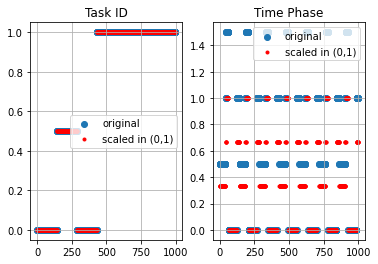

((2, 16128), (7, 16128))

In [15]:
task_id, time_phase_id = [],[]
add_temporal_features = [task_id, time_phase_id]
from sklearn.preprocessing import LabelEncoder
for j, temporal_feat in enumerate(["Task ID","Time Phase"]):
    
    plt.subplot(1,2,j+1)
    plt.title(temporal_feat)
    plt.scatter(np.arange(1000),df.iloc[-j-1,4:1004]/df.iloc[-1,4:].max(),label="original")
    le = LabelEncoder()
    add_feats_days = le.fit_transform(df.iloc[-j-1,4:])
    add_temporal_features[j] = add_feats_days/add_feats_days.max()
    plt.scatter(np.arange(1000),add_temporal_features[j][:1000],marker='.',c='r',label="scaled in (0,1)")
    plt.grid(True)
    plt.legend()
plt.show()
add_temporal_features = np.array(add_temporal_features)
add_temporal_features.shape,observed_values_from_sensors.shape

In [16]:
spacetimemaps = np.array(df.iloc[roadPositions][df.columns[4:]])
num_timestamps = spacetimemaps.shape[1]
num_days = int(num_timestamps/144)

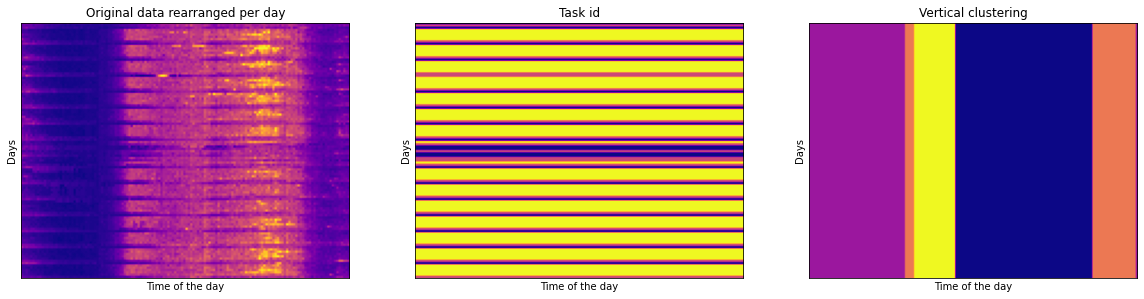

In [17]:
plt.figure(figsize=(20,7))
c=1
titles = ["Original data rearranged per day", "Task id", "Vertical clustering"]
for e in ([observed_values_from_sensors[1].reshape(num_days,144),
                      np.array(add_temporal_features[0]).reshape(num_days,144),
                      np.array(add_temporal_features[1]).reshape(num_days,144)
                     ]):
    plt.subplot(1,3,c)
    c+=1
    plt.imshow(e)
    plt.xlabel("Time of the day")
    plt.ylabel("Days")
    plt.xticks([],[])#my_x_ticks)
    plt.yticks([],[])
    plt.title(titles[c-2])

### Traffic flow observed data from sensors
With means, maxes and standard deviations

[ 1623  1834  2815  3131  3690  5924  9259 10367 11184 11361 11675 11728
 12521 12978 13905 14273 15409 15682 15756 16013]


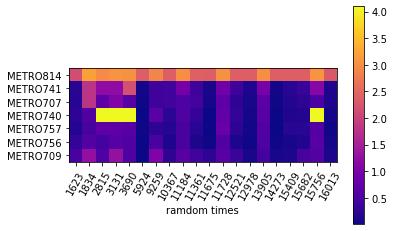

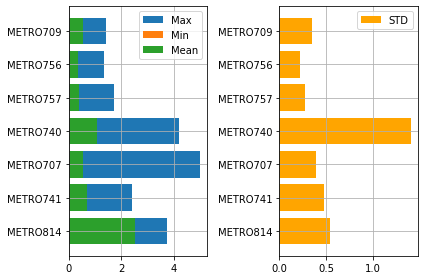

In [18]:
rnd_obs = 20
rnd_idx = np.sort(np.random.rand(rnd_obs)*observed_values_from_sensors.shape[1]).astype(np.int)
print(rnd_idx)
plt.imshow(observed_values_from_sensors[:,rnd_idx])
plt.colorbar()
plt.yticks(np.arange(num_sensors),sensorName)
plt.xticks(np.arange(rnd_obs),rnd_idx,rotation=60)
plt.xlabel("ramdom times")
plt.show()
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.subplot(1,2,1)

plt.barh(np.arange(num_sensors),observed_values_from_sensors.max(axis=1),label="Max")
plt.barh(np.arange(num_sensors),observed_values_from_sensors.min(axis=1),label="Min")
plt.barh(np.arange(num_sensors),observed_values_from_sensors.mean(axis=1),label="Mean")
#plt.barh(np.arange(num_sensors),np.median(observed_values_from_sensors,axis=1),label="Median")
plt.yticks(np.arange(num_sensors),sensorName)
#plt.yticks(np.arange(num_sensors),sensorName)
plt.grid(True)
plt.legend()
plt.subplot(1,2,2)
plt.barh(np.arange(num_sensors),observed_values_from_sensors.std(axis=1),label="STD",color='orange')
plt.yticks(np.arange(num_sensors),sensorName)
plt.grid(True)
plt.legend()
plt.tight_layout()

Indexes of the dataframes used as portion of the road graph to select the subdataset that do not involve the results of the FEM method.

In [19]:
#roadPositions = roadPositions[0]
roadPositions

array([ 25, 369, 388, 397, 463, 513, 709])

### Visualization of samples of the dataset

[ 1623  1834  2815  3131  3690  5924  9259 10367 11184 11361 11675 11728
 12521 12978 13905 14273 15409 15682 15756 16013]
(7, 20)


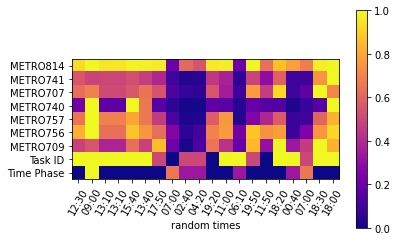

(7, 20)


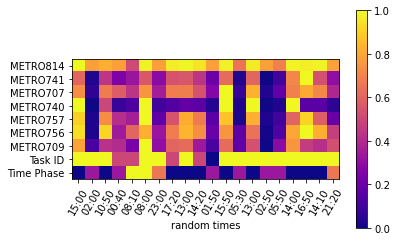

In [20]:
rnd_obs = 20

print(rnd_idx)
n_time_stamps = rnd_obs 
for tille in np.random.rand(2):#[6870,3138]:#
    rnd_idx = np.sort(np.random.rand(rnd_obs)*spacetimemaps.shape[1]).astype(int)
    my_x_ticks = timestamps_labels[rnd_idx%144]#((np.arange(n_time_stamps)+start)%144)]
    np.array(df.iloc[roadPositions][df.columns[4:][:]])
    spacetimemaps2 = np.array(df.iloc[roadPositions][df.columns[4:][rnd_idx]])#df[df.columns[4:]].iloc[idxs])
    spacetimemaps2 = (spacetimemaps2/spacetimemaps2.max(axis=1).reshape(7,1))
    spacetimemaps2plot = np.vstack([spacetimemaps2,add_temporal_features[:,rnd_idx]])
    print(spacetimemaps2.shape)
    plt.imshow(spacetimemaps2plot)

    plt.colorbar()

    plt.yticks(np.arange(len(roadPositions)+2),list(my_y_ticks)+["Task ID","Time Phase"])
    plt.xticks(np.arange(rnd_obs),my_x_ticks,rotation=60)
    plt.xlabel("random times")
    plt.show()


## Dataset split for evaluation
We decide that we want to veryfy the goodness of the model, by each task id, in a fixed fashion that means we use the last absolute 3500 fixed tiestamps. 

We repeat the experiments k times to assest the goodness of the approaches with respect to the SRA4TF

$$
Train set_{k} = [<X_{k train SAT},Y_{k train SAT}>,<X_{k train SUN},Y_{k train SUN}>,<X_{k train WRK},Y_{k train WRK}>] 
$$

$$
Validation set_{k}  = [<X_{k val SAT},Y_{k val SAT}>,<X_{k val SUN},Y_{k val SUN}>,<X_{k val WRK},Y_{k val WRK}>] 
$$


Each one of the k dataset settings for the LOOCV are of the form:
$$
<X_{k train DAY_j},Y_{k train DAY_j}> = 
\{ <O_{i}(t)> | t < 12628  \land i \ne k \land t \in indexes_{DAY_j} \},\{O_{k}(t)|t<12628 \land t \in indexes_{DAY_j}\}
$$


In a similar manner is defined the Validation set

$$
<X_{k val DAY_j},Y_{k val DAY_j}> = 
\{ <O_{i}(t)> | t \ge 12628  \land i \ne k \land t \in indexes_{DAY_j} \},\{O_{k}(t)|t \ge 12628 \land t \in indexes_{DAY_j}\}
$$
We want to minimize the error:
$$
Validation MAE_k  = \frac{\sum_{t=1}^T |O_{k}(t)-\hat O_{k}(t)|}{T}, \forall t>12628
$$
for each of the k sensors, in Leave One Out Cross Validation fashion. Having as aim finding the model that perform the best _overall_ the k MAEs of the $Validation_{set}$


#### Validation set splitting
Splitting training data in train and validation with the equivalent percentage of 3500 timestamps over the whole dataset but grouped by each task.

In [21]:

test_index = 3500
num_timestamps,"total samples",num_days,"total days",test_index,"number of test timestamps",num_timestamps-test_index,"last index of train"

(16128,
 'total samples',
 112,
 'total days',
 3500,
 'number of test timestamps',
 12628,
 'last index of train')

Take the 3500 timestamps as test, leave the other for training

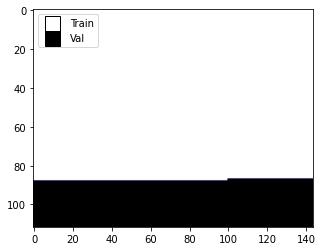

In [22]:
from matplotlib.lines import Line2D
tr_te_split = np.arange(num_timestamps)
tr_te_split2 = np.zeros(num_timestamps)
tr_te_split2[tr_te_split<(num_timestamps-test_index)] = 1
fig, ax = plt.subplots()
plt.imshow(tr_te_split2.reshape(num_days,144),interpolation=None,cmap='bone')
legend_elements = [Line2D([0], [0], marker='s', color='k', label='Train',lw=0,
                          markerfacecolor='w', markersize=15),
                  Line2D([0], [0], marker='s', color='k', label='Val',lw=0,
                          markerfacecolor='k', markersize=15)]
ax.legend(handles=legend_elements, loc='upper left')

In [23]:
spacetimemaps.shape

(7, 16128)

## Setting the stage
The baselines alltogheter with long with the Experimental Settings of Continual Learning training Patterns

[0.  0.5 1. ]


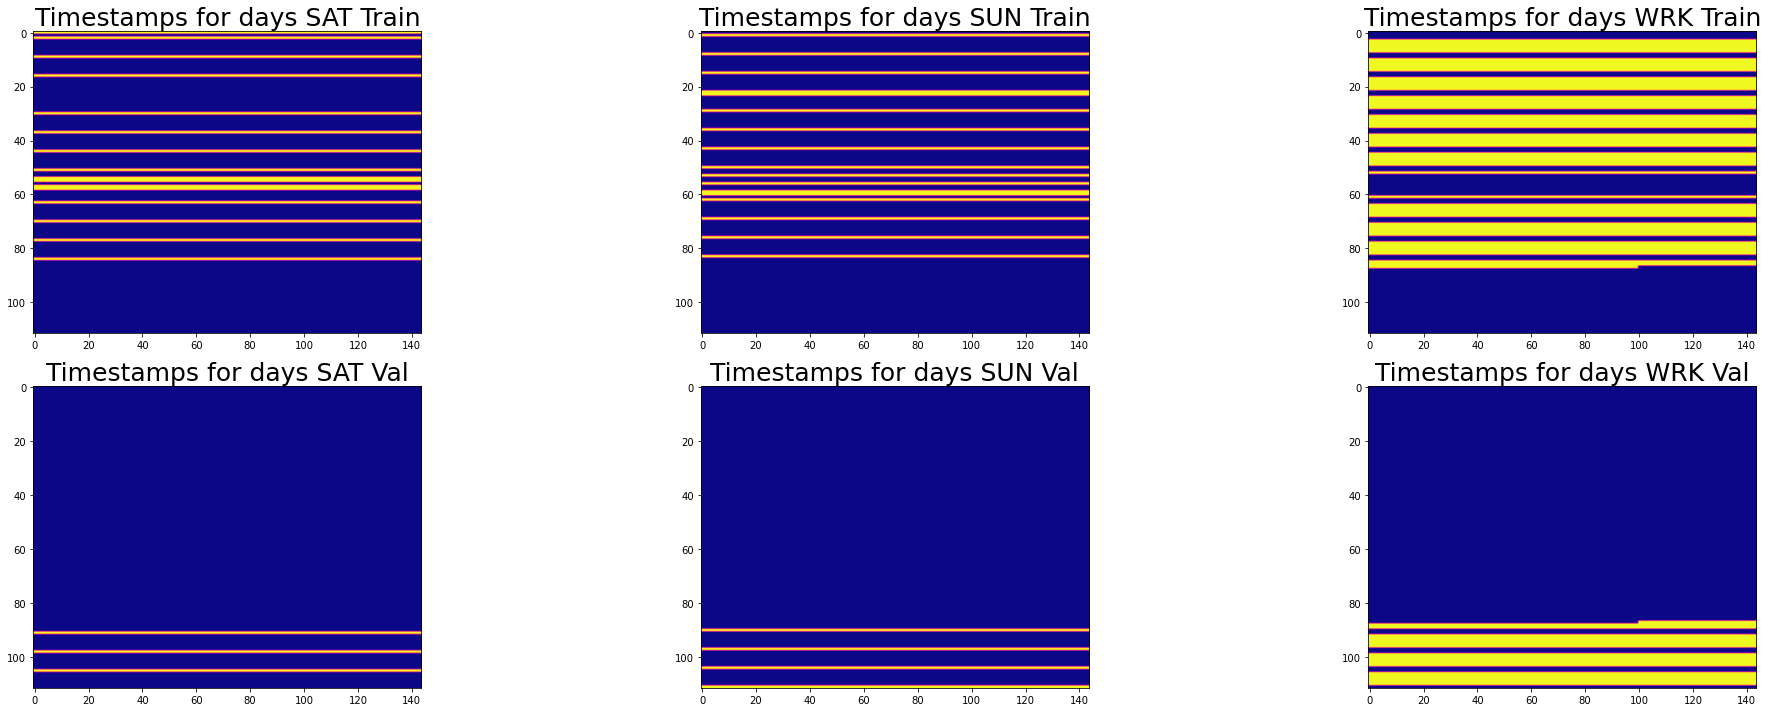

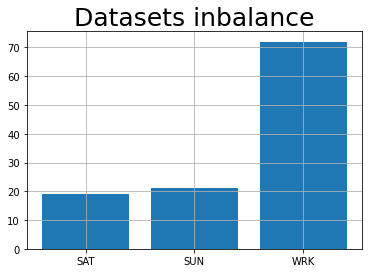

In [24]:
day_task_values = np.unique(add_temporal_features[0])
print(day_task_values)
#for e in 
plt.figure(figsize=(30,10))

X = []
X_idxs = []
for i,phase in enumerate([True,False]):
    for j,e in enumerate(day_task_values):
        plt.subplot(2,3,j+1+i*3)
        
        task_idxs = np.where(add_temporal_features[0]==e)[0]
        if phase:
            X_idxs.append(task_idxs)

        test_m = np.zeros(num_timestamps)
        test_m[task_idxs] = 1
        test_m = test_m.reshape(num_days,144)
        if phase:
            X.append(spacetimemaps[:,task_idxs])
        #print(type(spacetimemaps[:,task_idxs]))
        plt.title("Timestamps for days "+str(["SAT","SUN","WRK"][j])+" "+["Train","Val"][i],fontsize=25)
        plt.imshow((tr_te_split2==phase).reshape(num_days,144)*test_m,interpolation=None)
plt.tight_layout()
plt.show()

#for el,el1 in zip(X,X_idxs):
    #print(el.shape,el.shape[1]/144,el1)
plt.bar(np.arange(3),[el.shape[1]/144 for el in X])
plt.title("Datasets inbalance",fontsize=25)
plt.xticks(np.arange(3),["SAT","SUN","WRK"])
plt.grid()

### Dataset division and creation of Tensors
Shaped in pattern according to compatibility for multitask learning using Avalanche.

In the next cell there is the implementation of the policy of chosing the last 3500 timestamps as validation set. There are roughly 21.7% of the whole dataset.

(In order to have 3500 time stamps we could have chosen to select roughty the 21.7% of each one of the subset that compose the data available for each task)

In [25]:
#3500: spacetimemaps.shape[1] = x : 100
"roughly",(3500*100)/spacetimemaps.shape[1],"days of validation"

('roughly', 21.70138888888889, 'days of validation')

In [26]:
spacetimemaps.shape[1]/100 * 21.7013

3499.985664

### Data structure
of the dataset from the tensor creation to the Avalanche Scenario

Sketch of the data structore used to create the Scenario for Avalanche

In [27]:
s=0
s1 = 0
val_split = 21.70139
test_idxs = []

patterns = [[],[]]


print("TRAIN-VALIDATION:",100-val_split,"-",val_split)
for j,task_data in enumerate(X):
    
    print("task",str(j)+";","days:",task_data.shape[1]/144,"Total timestamps:",task_data.shape[1],"/ 100*",val_split)
    n_d = task_data.shape[1]/144
    factor = int( 144*(n_d) * val_split/100)
    s+=factor
    print("\t","validation days:",np.round(factor/144,2),"timestamps:",factor)
    test_mask = X_idxs[j]>=num_timestamps-3500
    y_t = np.array(X[j][-1,~test_mask]).T.reshape(-1,1)
    y_te = np.array(X[j][-1,test_mask]).T.reshape(-1,1)
    x_t = X[j][:-1,~test_mask]
    x_te = X[j][:-1,test_mask]

    patterns[0].append((torch.Tensor(x_t.T),torch.Tensor(y_t)))
    patterns[1].append((torch.Tensor(x_te.T),torch.Tensor(y_te)))
    orig_ts = np.sum(test_mask)
    orig_days = orig_ts/144
    s1+=orig_ts
    print("\t","validation days:",orig_days,"timestamps:",orig_ts)
    print(X[j][:,test_mask].shape)
    print(np.sum(test_mask),np.sum(~test_mask))
    
s,s1

TRAIN-VALIDATION: 78.29861 - 21.70139
task 0; days: 19.0 Total timestamps: 2736 / 100* 21.70139
	 validation days: 4.12 timestamps: 593
	 validation days: 3.0 timestamps: 432
(7, 432)
432 2304
task 1; days: 21.0 Total timestamps: 3024 / 100* 21.70139
	 validation days: 4.56 timestamps: 656
	 validation days: 4.0 timestamps: 576
(7, 576)
576 2448
task 2; days: 72.0 Total timestamps: 10368 / 100* 21.70139
	 validation days: 15.62 timestamps: 2250
	 validation days: 17.305555555555557 timestamps: 2492
(7, 2492)
2492 7876


(3499, 3500)

In [28]:
for el in patterns:#2 list of train / test items
    print(type(el))
    for el2 in el:
        print("\t",type(el2))
        for el3 in el2:
            print("\t\t",type(el3),el3.shape)
    print()

<class 'list'>
	 <class 'tuple'>
		 <class 'torch.Tensor'> torch.Size([2304, 6])
		 <class 'torch.Tensor'> torch.Size([2304, 1])
	 <class 'tuple'>
		 <class 'torch.Tensor'> torch.Size([2448, 6])
		 <class 'torch.Tensor'> torch.Size([2448, 1])
	 <class 'tuple'>
		 <class 'torch.Tensor'> torch.Size([7876, 6])
		 <class 'torch.Tensor'> torch.Size([7876, 1])

<class 'list'>
	 <class 'tuple'>
		 <class 'torch.Tensor'> torch.Size([432, 6])
		 <class 'torch.Tensor'> torch.Size([432, 1])
	 <class 'tuple'>
		 <class 'torch.Tensor'> torch.Size([576, 6])
		 <class 'torch.Tensor'> torch.Size([576, 1])
	 <class 'tuple'>
		 <class 'torch.Tensor'> torch.Size([2492, 6])
		 <class 'torch.Tensor'> torch.Size([2492, 1])



## Input and output number definition

In [29]:
num_units = 1#patterns[0][0][1].shape[1]
input_size = 6#1
input_size,num_units

(6, 1)

#### Strategies from avalanche

In [30]:
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
Cumulative, LwF, GEM, AGEM, EWC, SynapticIntelligence, LFL, AGEM,CoPE




## Scenario Creation

In [31]:
#create Datasets
from avalanche.benchmarks import ni_benchmark,nc_benchmark,tensors_benchmark

#create benchmark
benchmark = tensors_benchmark(train_tensors =  patterns[0],
                  test_tensors = patterns[1] ,
                  task_labels = [0,1,2])#"Festive","Semifestive","Working"]) 

## Definitions of Metrics + evaluations
The chosen metrics are the MSE loss, used as main metric. 

The forward and backward learning are also took into account

In [32]:
from torch.optim import SGD
from avalanche.evaluation.metrics import forgetting_metrics, loss_metrics,forward_transfer
from avalanche.models import SimpleMLP
from avalanche.logging import InteractiveLogger,TextLogger
from avalanche.training.plugins import EvaluationPlugin, EarlyStoppingPlugin
from avalanche.training import Naive,JointTraining



## Baselines 
from the world of ML, no continually involved techniques. Somehow my banchmarks models

### Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

In [34]:
all_losses = {}

### Dataset strucutred for the ML models
Dataset structured for the "MultiHead" or multioutput models

In [35]:
X_forest_tr = list(patterns[0][0][0])+list(patterns[0][1][0])+list(patterns[0][2][0])
y_forest_tr = [list(e) for e in list(patterns[0][0][1])]+[list(e) for e in list(patterns[0][1][1])]+[list(e) for e in list(patterns[0][2][1])]
X_forest_te = [list(patterns[1][0][0]),list(patterns[1][1][0]),list(patterns[1][2][0])]
y_forest_te = [[list(e) for e in list(patterns[1][0][1])],[list(e) for e in list(patterns[1][1][1])],[list(e) for e in list(patterns[1][2][1])]]

X_forest_tr = [np.array(el) for el in X_forest_tr]
len(X_forest_tr),len(y_forest_tr),len(X_forest_te),len(y_forest_te)

(12628, 12628, 3, 3)

In [36]:
MO_X_tr = [np.array(patterns[0][0][0]),
                np.array(patterns[0][1][0]),
                np.array(patterns[0][2][0])]
MO_Y_tr =   [[np.array(e) for e in list(patterns[0][0][1])],
                [np.array(e) for e in list(patterns[0][1][1])],
                [np.array(e) for e in list(patterns[0][2][1])]]
MO_X_te = [np.array(patterns[1][0][0]),
               np.array(patterns[1][1][0]),
               np.array(patterns[1][2][0])]
MO_Y_te = [
            [np.array(e) for e in list(patterns[1][0][1])],
            [np.array(e) for e in list(patterns[1][1][1])],
            [np.array(e) for e in list(patterns[1][2][1])]
]
'''for s in [MO_X_tr,MO_Y_tr,MO_X_te,MO_Y_te]:
    print(len(s))
    for el in s:
        print(len(el))
    print()'''


'for s in [MO_X_tr,MO_Y_tr,MO_X_te,MO_Y_te]:\n    print(len(s))\n    for el in s:\n        print(len(el))\n    print()'

##### Dictionary to keep the losses values

In [37]:
techiques = ['RandomForest', 'RandomForestMH', 'LinearModel', 'LinearModelsMH', 'Naive', 'Joint', 'Cumulative', 'GDumb', 'Replay', 'GEM', 'EWC', 'SynapticIntelligence', 'LFL']
all_losses = {k:[] for k in techiques}
all_losses.keys()

dict_keys(['RandomForest', 'RandomForestMH', 'LinearModel', 'LinearModelsMH', 'Naive', 'Joint', 'Cumulative', 'GDumb', 'Replay', 'GEM', 'EWC', 'SynapticIntelligence', 'LFL'])

### Random Forest Regressor and MultiHead RFr

Random forest and the Multihead Regressor Random Forest used as benchmarks

In [38]:
tries = 10
for kfold in range(tries):
    print(kfold+1,"/",tries)
    rgr = RandomForestRegressor(n_estimators=25,max_depth=7)#MultiOutputRegressor(RandomForestRegressor())#n_estimators=25,max_depth=7))
    rgr.fit(X_forest_tr,np.array(y_forest_tr).ravel())
    forest_loss = []
    for x_te,y_te in zip(X_forest_te,y_forest_te):
        y_te_pr = rgr.predict([np.array(el) for el in x_te])
        forest_loss.append(mean_absolute_error(y_te,y_te_pr))
    forest_loss = np.array(forest_loss)
    all_losses["RandomForest"] = all_losses["RandomForest"]+[forest_loss]



    #Multihead
    rgrs = [RandomForestRegressor(),RandomForestRegressor(),RandomForestRegressor()]
    forest2_loss = []
    for rgr,X_tr,y_tr,X_te,Y_te in zip(rgrs,MO_X_tr,MO_Y_tr,MO_X_te,MO_Y_te):
        #print(,np.array(y_tr).reshape(-1,1).shape)
        rgr.fit(np.array(X_tr),np.array(y_tr).ravel())
        y_te_pr = rgr.predict([np.array(el) for el in X_te])
        forest2_loss.append(mean_absolute_error(Y_te,y_te_pr))


    forest2_loss = np.array(forest2_loss)
    all_losses["RandomForestMH"] = all_losses["RandomForestMH"]+[forest2_loss]

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [39]:
from CLplotting import *

(3, 4) (3,)
[[0.83099844 0.37620329 0.20204677 1.        ]
 [0.468401   0.50931541 0.4503434  1.        ]
 [0.52128171 0.82086167 0.3002336  1.        ]]


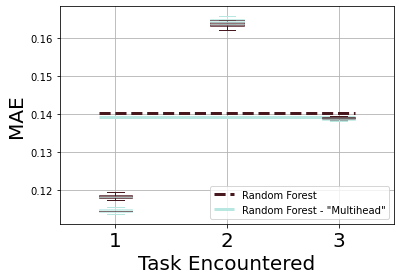

In [40]:
mainc = np.random.rand(4)

plots_single_metric_box(losses=np.array(all_losses["RandomForest"]),
                        strategy_name="Random Forest",
                        num_tasks=3,
                        main_color=mainc,
                         #main_color="k",
                         line_style='--',
                       draw_single_tasks=False)
plots_single_metric_box(losses=np.array(all_losses["RandomForestMH"]),
                        strategy_name="Random Forest - \"Multihead\"",
                         metric_name="MAE",
                        main_color=complementary(mainc),
                        line_style='-',
                        draw_single_tasks=False)

The Random Forest is the best model when comparing them with the following strategies,

There is not really a better model, they are both performing very similarly.

### Linear Model and MultiHead LM

In [41]:
for kfold in range(tries):
    print(kfold+1,"/",tries)
    #Single
    rgr = BayesianRidge()
    rgr.fit(X_forest_tr,np.array(y_forest_tr).ravel())
    LM_loss = []
    for x_te,y_te in zip(X_forest_te,y_forest_te):
        y_te_pr = rgr.predict([np.array(el) for el in x_te])
        LM_loss.append(mean_absolute_error(y_te,y_te_pr))
    LM_loss = np.array(LM_loss)
    all_losses["LinearModel"] = all_losses["LinearModel"]+[LM_loss]


    #Multihead
    rgrs = [BayesianRidge(),BayesianRidge(),BayesianRidge()]


    LM2_loss = []
    for rgr,X_tr,y_tr,X_te,Y_te in zip(rgrs,MO_X_tr,MO_Y_tr,MO_X_te,MO_Y_te):
        #print(,np.array(y_tr).reshape(-1,1).shape)
        rgr.fit(np.array(X_tr),np.array(y_tr).ravel())
        y_te_pr = rgr.predict([np.array(el) for el in X_te])
        LM2_loss.append(mean_absolute_error(Y_te,y_te_pr))
        #print("COEFS",rgr.coef_)


    LM2_loss = np.array(LM2_loss)
    all_losses["LinearModelsMH"] = all_losses["LinearModelsMH"]+[LM2_loss]

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


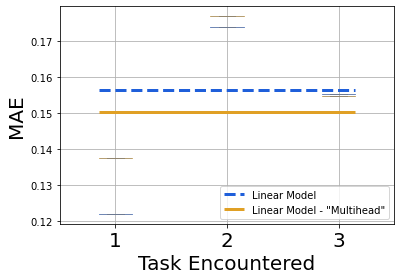

In [42]:
plt.clf()
mainc = np.random.rand(4)
plots_single_metric_box(losses=np.array(all_losses["LinearModel"]),
                        metric_name="MAE",
                        strategy_name="Linear Model",
                        main_color=mainc,
                         line_style='--',
                   )
plots_single_metric_box(losses=np.array(all_losses["LinearModelsMH"]),
                        strategy_name="Linear Model - \"Multihead\"",
                        metric_name="MAE",
                        main_color=complementary(mainc),
                        line_style='-',
                        #draw_points=True,
                        #draw_single_tasks=True
                       )
    


The Linear Model is included for the sake of completeness with Machine Learning baselines. Its expressiveness however is pretty poor and limited.

The model is capable to catch the relationships between the sensors but limited in the amount of paremters. The multihead design is naturally better than the vanilla "mono-headed"one.

## Neural Network models

Here we are going to use the implementation of the basic continual learning strategies of Avalanche.
The topology of the netowrk is fixed in the function baseMLPmodel, the optimizer is the stocastic gradient Discent with lr of 0.001 and a momentum of 0.7. The loss used as criterion is the Mean Absolute Error (L1Loss).

### Model Definition

In [43]:
from torch.optim import SGD
from torch.nn import MSELoss,L1Loss
from avalanche.models import SimpleMLP

def baseMLPmodel(num_units_nn=1,input_size=6,h_layers=2,h_size=128,dropout=.3,learning_rate=0.001,momentum=.7,verbose=False):
    model = SimpleMLP(num_classes=num_units_nn,hidden_layers=h_layers,hidden_size=h_size,input_size=input_size,drop_rate=dropout)
    optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    criterion = L1Loss()
    if verbose:
        print("Model has",input_size,"inputs and",num_units_nn,"outputs")
        print(model)
    return model,optimizer,criterion
print(baseMLPmodel()[0])

SimpleMLP(
  (features): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
    )
  )
  (classifier): Linear(in_features=128, out_features=1, bias=True)
)


### Evaluation Plugin
One for each run but all equals

In [44]:
def NewEvalPlugin(benchmark):
    eval_plugin = EvaluationPlugin(
        loss_metrics(minibatch=False, epoch=False, experience=True, stream=False),
        forgetting_metrics(experience=True, stream=False),
        collect_all=True,
        loggers=[TextLogger(open('log.txt', 'w+'))],
        benchmark=benchmark,
        strict_checks=False
    )
    return eval_plugin
NewEvalPlugin(benchmark)

### Strategy training and Metrics Retrievement from the results

In [45]:
## TRAINING PHASE
# TRAINING LOOP
def train_strategy(cl_strategy,benchmark,verbose=False):
    if verbose:
        print('Starting experiment...')
    results = []
    for experience in benchmark.train_stream:
        #
        #print("Current Classes: ", experience.classes_in_this_experience)
        cl_strategy.train(experience)
        results.append(cl_strategy.eval(benchmark.test_stream))
    if verbose:
        print('Training completed')
        print('Computing accuracy on the whole test set')
        
    return results

def get_losses(eval_plugin, num_tasks=3,verbose=False):
    losses = np.array([])
    for exp in range(num_tasks):
        key = "Loss_Exp/eval_phase/test_stream/Task{:03d}/Exp{:03d}".format(exp,exp)
        a_l = np.array(eval_plugin.get_all_metrics()[key][1])
        if verbose:
            print(key)
            print(eval_plugin.get_all_metrics()[key])
            print(a_l)
        losses = np.vstack([losses,a_l]) if losses.size else a_l
    return losses

### Naive Approach
---
Finetuning: just continue Backpropagation

#### Strategy definition
This is the naive baseline, just keep optimizing with optimizer meanwhile the tasks come altogheter.

In [46]:
all_losses["Naive"]=[]
for kfold in range(tries):
    print(kfold+1,"/",tries)
    ##INIT MODEL, OPTIMIZATER, and Loss Function
    model,optimizer,criterion = baseMLPmodel()
    #INIT PLUGIN FOR STRATEGY EVALUATION
    eval_plugin = NewEvalPlugin(benchmark)
    early_stopping_plugin = EarlyStoppingPlugin(patience=2, val_stream_name='train_stream',metric_name = 'Loss_Exp',mode="min")

    cl_strategy = Naive(model,
                        optimizer,
                        criterion,
                        train_epochs=30,
                        plugins=[early_stopping_plugin],
                        evaluator=eval_plugin)

    train_strategy(cl_strategy,benchmark)

    all_losses["Naive"] = all_losses["Naive"] + [get_losses(eval_plugin)]

1 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadec1dd1c0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Naive object at 0x7fadec1dd220>. This may result in errors.
  warnings.warn(
/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/plugins/early_stopping.py:94: UserWarning: Metric Loss_Exp used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


2 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadec0f1eb0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Naive object at 0x7fadec0f1e80>. This may result in errors.
  warnings.warn(


3 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadec188a60> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Naive object at 0x7fadec188a90>. This may result in errors.
  warnings.warn(


4 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadec08f5b0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Naive object at 0x7fadec08f910>. This may result in errors.
  warnings.warn(


5 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadec08f5e0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Naive object at 0x7fadec08fd90>. This may result in errors.
  warnings.warn(


6 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadec0f1520> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Naive object at 0x7fadec0f1190>. This may result in errors.
  warnings.warn(


7 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadec0f1760> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Naive object at 0x7fadec0f1dc0>. This may result in errors.
  warnings.warn(


8 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadec08fbb0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Naive object at 0x7fadec08f760>. This may result in errors.
  warnings.warn(


9 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadec08f8b0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Naive object at 0x7fadec08f940>. This may result in errors.
  warnings.warn(


10 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadec0f1730> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Naive object at 0x7fadec0f1220>. This may result in errors.
  warnings.warn(


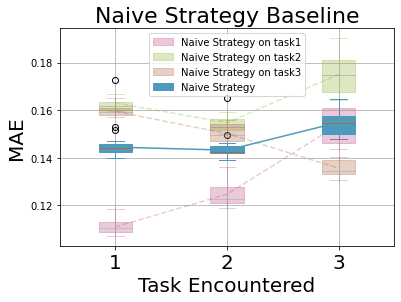

In [47]:
from CLplotting import * 
start_C = KMeans(n_clusters=num_tasks).fit(np.random.rand(600).reshape(200,3)).cluster_centers_
task_colors = np.vstack([start_C,0.3*np.ones(num_tasks)]).T
plots_for_many_tasks_box(losses=np.array(all_losses["Naive"]),
                     titl="Naive Strategy Baseline",
                     strategy_name="Naive Strategy",
                     metric_name="MAE",
                     task_colors=task_colors,
                     main_color=mainc,
                     line_style='-.',
                     #draw_single_tasks=True,
                     #draw_points=True
                    )

The Naive Strategy archieves a comparable result with the Random Forest Multihead (RFMH), however does not improve the performancies in terms of MAE. From the plots of the performancies, the model shows a bizarre behaviour. With more data the model does not improve. The first task is soon forgotten. The performancies on the second task do not improve significantly, especially during the training on its data. The knowledge acquired by the model is wostened after training on the last task dataset. The third task get some advantages from the training (forward learning).

### Joint Training Strategy
---
offline training. 

The best you can do with all the data starting from skretch (without the hindering of learning continually).
("joint-training" or "offline" method)

#### Strategy Definition

In [48]:
all_losses["Joint"] = []
for kfold in range(tries):
    print(kfold+1,"/",tries)
    ##INIT MODEL, OPTIMIZATER, and Loss Function
    model,optimizer,criterion = baseMLPmodel()
    #INIT PLUGIN FOR STRATEGY EVALUATION
    eval_plugin = NewEvalPlugin(benchmark)
    early_stopping_plugin = EarlyStoppingPlugin(patience=2, val_stream_name='train_stream',metric_name = 'Loss_Exp',mode="min")

    cl_strategy = JointTraining(
            model,
            optimizer,
            criterion,
            evaluator = eval_plugin,
            plugins=[early_stopping_plugin],
            train_mb_size=4,
            train_epochs=30,
            eval_mb_size=2,
        )

    ## DIFFERENT TRAIN "LOOP"/"ROUTINE" for Joint
    cl_strategy.train(benchmark.train_stream)
    cl_strategy.eval(benchmark.test_stream)

    all_losses["Joint"] = all_losses["Joint"] + [get_losses(eval_plugin)]


1 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadec0a3df0> implements incompatible callbacks for template <avalanche.training.supervised.joint_training.JointTraining object at 0x7fadec0a3f70>. This may result in errors.
  warnings.warn(
/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/plugins/early_stopping.py:94: UserWarning: Metric Loss_Exp used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


2 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadb9c8f910> implements incompatible callbacks for template <avalanche.training.supervised.joint_training.JointTraining object at 0x7fadb9c8f8e0>. This may result in errors.
  warnings.warn(


3 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadb9c8fdc0> implements incompatible callbacks for template <avalanche.training.supervised.joint_training.JointTraining object at 0x7fadb9c8fd90>. This may result in errors.
  warnings.warn(


4 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadec0f1880> implements incompatible callbacks for template <avalanche.training.supervised.joint_training.JointTraining object at 0x7fadec0f1d00>. This may result in errors.
  warnings.warn(


5 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadb9c8f0d0> implements incompatible callbacks for template <avalanche.training.supervised.joint_training.JointTraining object at 0x7fadb9c8f640>. This may result in errors.
  warnings.warn(


6 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadec188b80> implements incompatible callbacks for template <avalanche.training.supervised.joint_training.JointTraining object at 0x7fadec1889a0>. This may result in errors.
  warnings.warn(


7 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadb9c8f790> implements incompatible callbacks for template <avalanche.training.supervised.joint_training.JointTraining object at 0x7fadb9c8f880>. This may result in errors.
  warnings.warn(


8 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadec0a3f70> implements incompatible callbacks for template <avalanche.training.supervised.joint_training.JointTraining object at 0x7fadb9c56370>. This may result in errors.
  warnings.warn(


9 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadb9a8c8e0> implements incompatible callbacks for template <avalanche.training.supervised.joint_training.JointTraining object at 0x7fadb9a8cb80>. This may result in errors.
  warnings.warn(


10 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.early_stopping.EarlyStoppingPlugin object at 0x7fadb9a8c940> implements incompatible callbacks for template <avalanche.training.supervised.joint_training.JointTraining object at 0x7fadb9a8cdc0>. This may result in errors.
  warnings.warn(


In [49]:
np.array(all_losses["Joint"]).T[0].T.shape,np.array(all_losses["RandomForest"]).shape
all_losses["Joint"]=np.array(all_losses["Joint"]).T[0].T

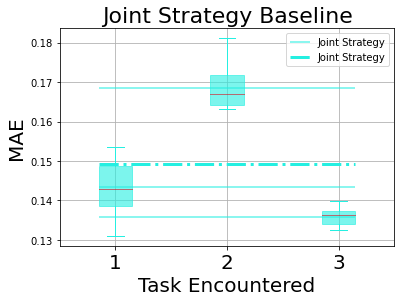

In [51]:
plt.clf()
#for ll in np.array(all_losses["Joint"]):
plots_single_metric_box(losses=np.array(all_losses["Joint"]),
                     titl="Joint Strategy Baseline",
                     strategy_name="Joint Strategy",
                     metric_name="MAE",
                     task_colors=task_colors,
                     main_color=np.random.rand(4),
                     line_style='-.',
                     draw_single_tasks=True
                    )
plt.show()

The Join Strategy achieve good results, and is in line with the performancies of the other ML model's results and baselines.

As being another DL baseline, we consider its score as something to improve.

### Cumulative Training
---
Cumulative training strategy


At each experience, train model with data from all previous experiences and current experience.


#### Strategy Definition

In [52]:
all_losses["Cumulative"] = []
for kfold in range(tries):
    print(kfold+1,"/",tries)
    ##INIT MODEL, OPTIMIZATER, and Loss Function
    model,optimizer,criterion = baseMLPmodel()
    #INIT PLUGIN FOR STRATEGY EVALUATION
    eval_plugin = NewEvalPlugin(benchmark)
    early_stopping_plugin = EarlyStoppingPlugin(patience=2, val_stream_name='train_stream',metric_name = 'Loss_Exp',mode="min")

    #Strategy
    cumulative_train_strategy = Cumulative(
            model,
            optimizer,
            criterion,
            evaluator = eval_plugin,
             train_mb_size=4,
            train_epochs=30,
            eval_mb_size=2,
        )

    train_strategy(cumulative_train_strategy,benchmark)

    all_losses["Cumulative"] = all_losses["Cumulative"]+[get_losses(eval_plugin)]





1 / 10
Loss_Exp/eval_phase/train_stream
2 / 10
Loss_Exp/eval_phase/train_stream
3 / 10
Loss_Exp/eval_phase/train_stream
4 / 10
Loss_Exp/eval_phase/train_stream
5 / 10
Loss_Exp/eval_phase/train_stream
6 / 10
Loss_Exp/eval_phase/train_stream
7 / 10
Loss_Exp/eval_phase/train_stream
8 / 10
Loss_Exp/eval_phase/train_stream
9 / 10
Loss_Exp/eval_phase/train_stream
10 / 10
Loss_Exp/eval_phase/train_stream


#### Evaluation performancies Plot

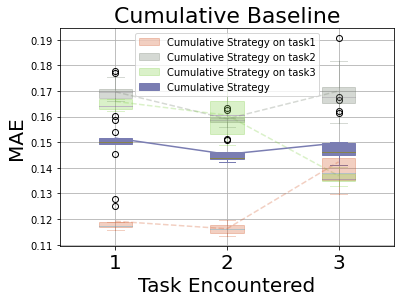

In [53]:
#CUMULATIVE

plots_for_many_tasks_box(losses=np.array(all_losses["Cumulative"]),
                     strategy_name="Cumulative Strategy",
                     metric_name="MAE",
                     main_color=np.random.rand(4),
                     titl='Cumulative Baseline',
                     line_style='-',
                     #draw_single_tasks=True
                   )
#plt.legend(loc="lower right")'''

The Cumulative strategy shows similar tendencies with the Naive training fashion, task one is forgotten and task two does not improve significantl. The thirs task is the one that gain most from the training.

### GDumb Plugin
Greedy sampler and Dumb Learner

#### Strategy Definition

In [54]:
all_losses["GDumb"] = []
for kfold in range(tries):
    print(kfold+1,"/",tries)
    ##INIT MODEL, OPTIMIZATER, and Loss Function
    model,optimizer,criterion = baseMLPmodel()
    #INIT PLUGIN FOR STRATEGY EVALUATION
    eval_plugin = NewEvalPlugin(benchmark)
    early_stopping_plugin = EarlyStoppingPlugin(patience=2, val_stream_name='train_stream',metric_name = 'Loss_Exp',mode="min")

    cl_strategy = GDumb(
            model,
            optimizer,
            criterion,
            evaluator = eval_plugin,
            train_mb_size=4,
            train_epochs=30,
            eval_mb_size=2,
            mem_size=144*2
        )

    train_strategy(cl_strategy,benchmark)

    all_losses["GDumb"] = all_losses["GDumb"] + [get_losses(eval_plugin)]




1 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gdumb.GDumbPlugin object at 0x7fadb97f0820> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GDumb object at 0x7fadb9919100>. This may result in errors.
  warnings.warn(


2 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gdumb.GDumbPlugin object at 0x7fad744800d0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GDumb object at 0x7fadb97f0730>. This may result in errors.
  warnings.warn(


3 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gdumb.GDumbPlugin object at 0x7fad75638b20> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GDumb object at 0x7fad74480190>. This may result in errors.
  warnings.warn(


4 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gdumb.GDumbPlugin object at 0x7fad74703910> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GDumb object at 0x7fad755c22b0>. This may result in errors.
  warnings.warn(


5 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gdumb.GDumbPlugin object at 0x7fadb89e2e20> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GDumb object at 0x7fad747038b0>. This may result in errors.
  warnings.warn(


6 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gdumb.GDumbPlugin object at 0x7fad74602370> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GDumb object at 0x7fad7514a400>. This may result in errors.
  warnings.warn(


7 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gdumb.GDumbPlugin object at 0x7fad75782370> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GDumb object at 0x7fad746022b0>. This may result in errors.
  warnings.warn(


8 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gdumb.GDumbPlugin object at 0x7fad747cb910> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GDumb object at 0x7fad75782460>. This may result in errors.
  warnings.warn(


9 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gdumb.GDumbPlugin object at 0x7fad74a03850> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GDumb object at 0x7fad747cb580>. This may result in errors.
  warnings.warn(


10 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gdumb.GDumbPlugin object at 0x7fad75509250> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GDumb object at 0x7fad74a03220>. This may result in errors.
  warnings.warn(


#### Evaluation performancies Plot
%plots_single_metric(losses=all_losses["GDumb"],
                     strategy_name="GDumb mean",
                     main_color="m",
                     line_style='-',
                     draw_single_tasks=True
                   )
plots_for_many_tasks(losses=all_losses["GDumb"],
                     strategy_name="GDumb baseline",
                     titl="GDumb baseline",
                     main_color="m",
                     line_style='--',
                     draw_single_tasks=True
                   )

In [55]:
np.array(all_losses["GDumb"]).shape

(10, 3, 3)

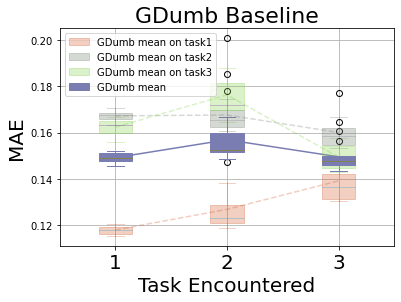

In [56]:
plots_for_many_tasks_box(losses=np.array(all_losses["GDumb"]),
                     strategy_name="GDumb mean",
                     titl="GDumb Baseline",
                     metric_name="MAE",
                     #main_color="m",
                     line_style='-',
                     #draw_single_tasks=True
                   )

The GDumb strategy has been thought to be applied in classification problems, however I wanted to include it as well in the experimentation. The sampling done in a greedy fashion somehow let the model give more attention to the assorted data points and the performancies on the task are in line with the other results.

### Experience replay plugin
---

Handles an external memory filled with randomly selected patterns and implementing before_training_exp and after_training_exp callbacks. The before_training_exp callback is implemented in order to use the dataloader that creates mini-batches with examples from both training data and external memory. The examples in the mini-batch is balanced such that there are the same number of examples for each experience.

#### Strategy Definition

In [57]:
all_losses["Replay"] = []
for kfold in range(tries):
    print(kfold+1,"/",tries)
    ##INIT MODEL, OPTIMIZATER, and Loss Function
    model,optimizer,criterion = baseMLPmodel()
    #INIT PLUGIN FOR STRATEGY EVALUATION
    eval_plugin = NewEvalPlugin(benchmark)
    early_stopping_plugin = EarlyStoppingPlugin(patience=2, val_stream_name='train_stream',metric_name = 'Loss_Exp',mode="min")

    cl_strategy = Replay(
            model,
            optimizer,
            criterion,

            evaluator = eval_plugin,
            train_mb_size=4,
            train_epochs=30,
            eval_mb_size=2,
        )

    train_strategy(cl_strategy,benchmark)

    all_losses["Replay"] = all_losses["Replay"] + [get_losses(eval_plugin)]




1 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.replay.ReplayPlugin object at 0x7fad745acca0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Replay object at 0x7fad75509760>. This may result in errors.
  warnings.warn(


2 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.replay.ReplayPlugin object at 0x7fad7450e4c0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Replay object at 0x7fad745acbb0>. This may result in errors.
  warnings.warn(


3 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.replay.ReplayPlugin object at 0x7fad744106d0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Replay object at 0x7fad7450ea60>. This may result in errors.
  warnings.warn(


4 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.replay.ReplayPlugin object at 0x7fad7434f430> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Replay object at 0x7fad74410790>. This may result in errors.
  warnings.warn(


5 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.replay.ReplayPlugin object at 0x7fad75532df0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Replay object at 0x7fad745ac970>. This may result in errors.
  warnings.warn(


6 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.replay.ReplayPlugin object at 0x7fad7434fcd0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Replay object at 0x7fad745acee0>. This may result in errors.
  warnings.warn(


7 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.replay.ReplayPlugin object at 0x7fad74507400> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Replay object at 0x7fad7434f940>. This may result in errors.
  warnings.warn(


8 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.replay.ReplayPlugin object at 0x7fad74300640> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Replay object at 0x7fad745079d0>. This may result in errors.
  warnings.warn(


9 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.replay.ReplayPlugin object at 0x7fad7434f580> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Replay object at 0x7fad7434fe50>. This may result in errors.
  warnings.warn(


10 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.replay.ReplayPlugin object at 0x7fad745acd30> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.Replay object at 0x7fad7434ffa0>. This may result in errors.
  warnings.warn(


In [58]:
np.array(all_losses["Replay"]).shape

(10, 3, 3)

#### Evaluation performancies Plot

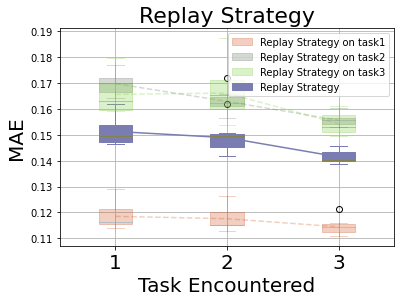

In [60]:
#REPLAY
plots_for_many_tasks_box(losses=np.array(all_losses["Replay"]),
                     titl="Replay Strategy",
                     strategy_name="Replay Strategy",
                     metric_name="MAE",
                     line_style='-',
                     #draw_single_tasks=True,
                     #draw_points=True
                   )

The Replay strategy is showing its peculiar characteristic: the first task is not hardly forget as it does in the offline baselines. The backward transfer learning happens after the training in both the following tasks. The performancies on the reconstruction of the traffic flow on the Festive days is retained and improved during the training on the third task.
The knowledge of the model with respect to the first and second task enjoys the backward transfer learning property.

### GEM Plugin
---
Gradient Episodic Memory

#### Strategy Definition

In [ ]:
all_losses["GEM"] = []
for kfold in range(tries):
    print(kfold+1,"/",tries)
    ##INIT MODEL, OPTIMIZATER, and Loss Function
    model,optimizer,criterion = baseMLPmodel()
    #INIT PLUGIN FOR STRATEGY EVALUATION
    eval_plugin = NewEvalPlugin(benchmark)
    early_stopping_plugin = EarlyStoppingPlugin(patience=2, val_stream_name='train_stream',metric_name = 'Loss_Exp',mode="min")

    cl_strategy = GEM(
            model,
            optimizer,
            criterion,
            patterns_per_exp = 144,
            evaluator = eval_plugin,
            train_mb_size=4,
            train_epochs=30,
            eval_mb_size=2,
        )
    train_strategy(cl_strategy,benchmark)

    all_losses["GEM"] = all_losses["GEM"] + [get_losses(eval_plugin)]


1 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gem.GEMPlugin object at 0x7fad742a6ee0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GEM object at 0x7fad745ace50>. This may result in errors.
  warnings.warn(


2 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gem.GEMPlugin object at 0x7fad745ac8b0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GEM object at 0x7fad742a6f10>. This may result in errors.
  warnings.warn(


3 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gem.GEMPlugin object at 0x7fad742aaaf0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GEM object at 0x7fad745ace80>. This may result in errors.
  warnings.warn(


4 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gem.GEMPlugin object at 0x7fad742aa1f0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GEM object at 0x7fad742aae20>. This may result in errors.
  warnings.warn(


5 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gem.GEMPlugin object at 0x7fad743c94c0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GEM object at 0x7fad742aa580>. This may result in errors.
  warnings.warn(


6 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gem.GEMPlugin object at 0x7fad742aa910> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GEM object at 0x7fad742aa340>. This may result in errors.
  warnings.warn(


7 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gem.GEMPlugin object at 0x7fad743c9760> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GEM object at 0x7fad742aa970>. This may result in errors.
  warnings.warn(


8 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gem.GEMPlugin object at 0x7fad742aabe0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GEM object at 0x7fad742aa8e0>. This may result in errors.
  warnings.warn(


9 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gem.GEMPlugin object at 0x7fad743c9520> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GEM object at 0x7fad742aae20>. This may result in errors.
  warnings.warn(


10 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.gem.GEMPlugin object at 0x7fad742aa850> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.GEM object at 0x7fad742aa910>. This may result in errors.
  warnings.warn(


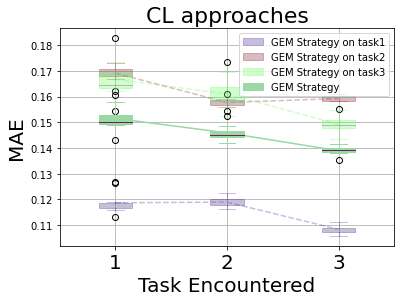

In [65]:

plots_for_many_tasks_box(losses=np.array(all_losses["GEM"]),
                     titl="CL approaches",
                     strategy_name="GEM Strategy",
                     main_color=np.random.rand(4),
                     task_colors=np.random.rand(12).reshape(3,4),
                     line_style='-',
                     metric_name='MAE'
                     #draw_single_tasks=True,
                     #draw_points=True,
                    )
#plt.ylabel("MAE",fontsize=20)

With the Gradient Episodic Memory the first task is not forgotten: the predictive power is retained in the forward trainings and the model achieves backward transfer on the first task.

The knowledge of the model on the second task is almost completely retained after the training on the third one. The third task enjoy the property of forward transfer.

### EWC Plugin
---
Elastic Wheight consolidation

#### Strategy Definition

In [66]:
all_losses["EWC"] = []
for kfold in range(tries):
    print(kfold+1,"/",tries)
    ##INIT MODEL, OPTIMIZATER, and Loss Function
    model,optimizer,criterion = baseMLPmodel()
    #INIT PLUGIN FOR STRATEGY EVALUATION
    eval_plugin = NewEvalPlugin(benchmark)
    early_stopping_plugin = EarlyStoppingPlugin(patience=2, val_stream_name='train_stream',metric_name = 'Loss_Exp',mode="min")

    cl_strategy = EWC(
            model,
            optimizer,
            criterion,
            evaluator = eval_plugin,
            ewc_lambda = .9,
            train_mb_size=4,
            train_epochs=30,
            eval_mb_size=2,
        )

    train_strategy(cl_strategy,benchmark)

    all_losses["EWC"] = all_losses["EWC"]+ [get_losses(eval_plugin)]





1 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.ewc.EWCPlugin object at 0x7fad73ef94f0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.EWC object at 0x7fad742aa6d0>. This may result in errors.
  warnings.warn(


2 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.ewc.EWCPlugin object at 0x7fad73ef9940> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.EWC object at 0x7fad73ef9520>. This may result in errors.
  warnings.warn(


3 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.ewc.EWCPlugin object at 0x7fad755329a0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.EWC object at 0x7fad73ef9970>. This may result in errors.
  warnings.warn(


4 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.ewc.EWCPlugin object at 0x7fad742aaa60> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.EWC object at 0x7fad743c9880>. This may result in errors.
  warnings.warn(


5 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.ewc.EWCPlugin object at 0x7fad73ef9280> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.EWC object at 0x7fad742aa6a0>. This may result in errors.
  warnings.warn(


6 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.ewc.EWCPlugin object at 0x7fad73ef96d0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.EWC object at 0x7fad73ef94c0>. This may result in errors.
  warnings.warn(


7 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.ewc.EWCPlugin object at 0x7fad73e3d970> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.EWC object at 0x7fad73ef94f0>. This may result in errors.
  warnings.warn(


8 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.ewc.EWCPlugin object at 0x7fad73ef9550> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.EWC object at 0x7fad73ef9790>. This may result in errors.
  warnings.warn(


9 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.ewc.EWCPlugin object at 0x7fad73ef9a30> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.EWC object at 0x7fad73ef9a60>. This may result in errors.
  warnings.warn(


10 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.ewc.EWCPlugin object at 0x7fad73e3ddc0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.EWC object at 0x7fad73ef95e0>. This may result in errors.
  warnings.warn(


#### Evaluation performancies Plot

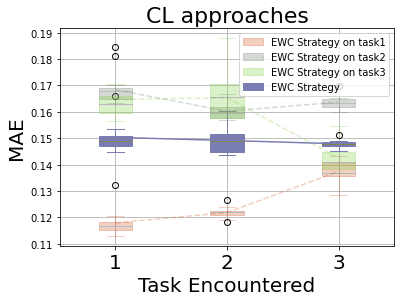

In [67]:

plots_for_many_tasks_box(losses=np.array(all_losses["EWC"]),
                     titl="CL approaches",
                     strategy_name="EWC Strategy",
                     metric_name="MAE",
                     main_color=np.random.rand(4),
                     line_style='--',
                     #draw_single_tasks=True,
                     #draw_points=True,
                    )

#plt.ylabel("MAE",fontsize=20)

From then Elastic Weigth Consolidation strategy it appreciable the error on the first task after the training on the second one. Performancies remain good after the trainin on the second task, however the model trained with EWC struggles to keep the same performancies after the training on the third task. The std deviation on the errors of the first task in the 10-fold shows an increase at that point. Knowledge of the second task does not get much words after the training on the third task.

### Synaptic Intelligence
---
Synaptic Intelligence

#### Strategy Definition

In [74]:
all_losses["SynapticIntelligence"] = []
for kfold in range(tries):
    print(kfold+1,"/",tries)
    ##INIT MODEL, OPTIMIZATER, and Loss Function
    model,optimizer,criterion = baseMLPmodel()
    #INIT PLUGIN FOR STRATEGY EVALUATION
    eval_plugin = NewEvalPlugin(benchmark)
    early_stopping_plugin = EarlyStoppingPlugin(patience=2, val_stream_name='train_stream',metric_name = 'Loss_Exp',mode="min")

    cl_strategy = SynapticIntelligence(
            model,
            optimizer,
            criterion,
            si_lambda = 1/3,
            evaluator = eval_plugin,
            train_mb_size=4,
            train_epochs=30,
            eval_mb_size=2,
        )

    train_strategy(cl_strategy,benchmark)

    all_losses["SynapticIntelligence"] = all_losses["SynapticIntelligence"]+ [get_losses(eval_plugin)]



1 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/plugins/synaptic_intelligence.py:65: UserWarning: The Synaptic Intelligence plugin is in an alpha stage and is not perfectly aligned with the paper implementation. Please use at your own risk!
  warnings.warn(
/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.synaptic_intelligence.SynapticIntelligencePlugin object at 0x7fad7384aac0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.SynapticIntelligence object at 0x7fad73b7fdc0>. This may result in errors.
  warnings.warn(


2 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.synaptic_intelligence.SynapticIntelligencePlugin object at 0x7fad736868b0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.SynapticIntelligence object at 0x7fad73686d60>. This may result in errors.
  warnings.warn(


3 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.synaptic_intelligence.SynapticIntelligencePlugin object at 0x7fad736867f0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.SynapticIntelligence object at 0x7fad73686a90>. This may result in errors.
  warnings.warn(


4 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.synaptic_intelligence.SynapticIntelligencePlugin object at 0x7fad73643e20> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.SynapticIntelligence object at 0x7fad73686250>. This may result in errors.
  warnings.warn(


5 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.synaptic_intelligence.SynapticIntelligencePlugin object at 0x7fad73681670> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.SynapticIntelligence object at 0x7fad73686760>. This may result in errors.
  warnings.warn(


6 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.synaptic_intelligence.SynapticIntelligencePlugin object at 0x7fad73681b50> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.SynapticIntelligence object at 0x7fad73681490>. This may result in errors.
  warnings.warn(


7 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.synaptic_intelligence.SynapticIntelligencePlugin object at 0x7fad73686850> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.SynapticIntelligence object at 0x7fad736817f0>. This may result in errors.
  warnings.warn(


8 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.synaptic_intelligence.SynapticIntelligencePlugin object at 0x7fad73686460> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.SynapticIntelligence object at 0x7fad736865e0>. This may result in errors.
  warnings.warn(


9 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.synaptic_intelligence.SynapticIntelligencePlugin object at 0x7fad73681100> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.SynapticIntelligence object at 0x7fad736868b0>. This may result in errors.
  warnings.warn(


10 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.synaptic_intelligence.SynapticIntelligencePlugin object at 0x7fad73686610> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.SynapticIntelligence object at 0x7fad73681430>. This may result in errors.
  warnings.warn(


#### Evaluation performancies Plot

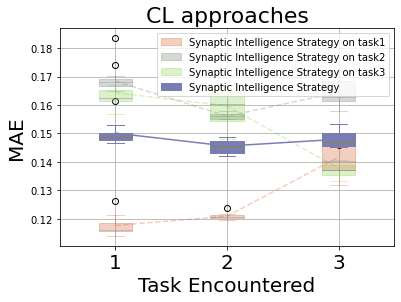

In [75]:

plots_for_many_tasks_box(losses=np.array(all_losses["SynapticIntelligence"]),
                     titl="CL approaches",
                     strategy_name="Synaptic Intelligence Strategy",
                     main_color=np.random.rand(4),
                     metric_name="MAE",
                     line_style='--',
                     #draw_single_tasks=True,
                     #draw_points=True,
                    )

#plt.ylabel("MAE",fontsize=20)

The performancies on the reconstruction of the traffic flow using the Synaptic Intelligence approach are worst than the previous ones. The forgetting is still present for the first task, specially after the training on task three. The forward tranfer phenomenon for the third task holds with this strategy as well. With the synaptic intelligence strategy the model still tends to deplete the performancies on second task. 

### LFL Plugin
---
Less Forgetful Learning strategy


In [76]:
all_losses["LFL"] = []
for kfold in range(tries):
    print(kfold+1,"/",tries)
    ##INIT MODEL, OPTIMIZATER, and Loss Function
    model,optimizer,criterion = baseMLPmodel()
    #INIT PLUGIN FOR STRATEGY EVALUATION
    eval_plugin = NewEvalPlugin(benchmark)
    early_stopping_plugin = EarlyStoppingPlugin(patience=2, val_stream_name='train_stream',metric_name = 'Loss_Exp',mode="min")

    cl_strategy = LFL(
            model,
            optimizer,
            criterion,
            lambda_e = 0.02,
            evaluator = eval_plugin,
            train_mb_size=4,
            train_epochs=30,
            eval_mb_size=2,
        )

    train_strategy(cl_strategy,benchmark)

    all_losses["LFL"] = all_losses["LFL"] + [get_losses(eval_plugin)]


1 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.lfl.LFLPlugin object at 0x7fadec07d340> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.LFL object at 0x7fad736865b0>. This may result in errors.
  warnings.warn(


2 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.lfl.LFLPlugin object at 0x7fadb93d0970> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.LFL object at 0x7fadec07d0a0>. This may result in errors.
  warnings.warn(


3 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.lfl.LFLPlugin object at 0x7fae898f45e0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.LFL object at 0x7fadb93d05e0>. This may result in errors.
  warnings.warn(


4 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.lfl.LFLPlugin object at 0x7fadb93d03d0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.LFL object at 0x7fae898f4940>. This may result in errors.
  warnings.warn(


5 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.lfl.LFLPlugin object at 0x7fadb99e0ee0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.LFL object at 0x7fadb93d0640>. This may result in errors.
  warnings.warn(


6 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.lfl.LFLPlugin object at 0x7fadb99e0040> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.LFL object at 0x7fadec07d520>. This may result in errors.
  warnings.warn(


7 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.lfl.LFLPlugin object at 0x7fad73681310> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.LFL object at 0x7fadb99e01f0>. This may result in errors.
  warnings.warn(


8 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.lfl.LFLPlugin object at 0x7fadb99e07f0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.LFL object at 0x7fae8819c8b0>. This may result in errors.
  warnings.warn(


9 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.lfl.LFLPlugin object at 0x7fadb924d0d0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.LFL object at 0x7fadb99e0610>. This may result in errors.
  warnings.warn(


10 / 10
Loss_Exp/eval_phase/train_stream


/home/bonsignori/.local/lib/python3.8/site-packages/avalanche/training/templates/base.py:200: UserWarning: Plugin <avalanche.training.plugins.lfl.LFLPlugin object at 0x7fadb99e07f0> implements incompatible callbacks for template <avalanche.training.supervised.strategy_wrappers.LFL object at 0x7fadb99e0c70>. This may result in errors.
  warnings.warn(


#### Evaluation performancies Plot

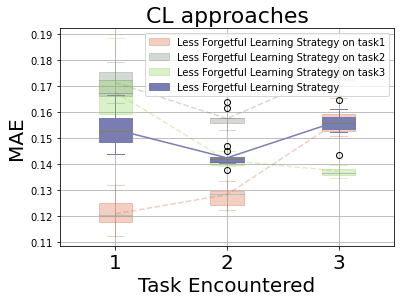

In [77]:
plots_for_many_tasks_box(losses=np.array(all_losses["LFL"]),
                     titl="CL approaches",
                     strategy_name="Less Forgetful Learning Strategy",
                     main_color=np.random.rand(4),
                     metric_name="MAE",
                     line_style='--',
                     #draw_single_tasks=True,
                     #draw_points=True,
                    )

#plt.ylabel("MAE",fontsize=20)

The less forgetful strategy does not returns a well performing model. The errors are higher than the previously tried strategies. The Continual Learning desiderata are not met with this strategy applied to this dataset. Forget is havily persistent among the first and second tasks.

## Final Ranking 
What's the best strategy?
From the results, it appears that the Gem strategy is even better than the ML best baseline, followed by the Replay strategy. The two version of the random forest, vanilla and multi-head verison hold the second and third position

In [78]:
#the final evaluation, i.e. the score on the reconstructed unit performed by the totally learned form of strategy
final_losses = { k : np.array(v) for (k,v) in all_losses.items()}
#final_losses = all_losses
#sorted(list(all_losses.items()),key=lambda x:np.array(x[1]).mean())
MANY_epoch_learners_NAMES = [k for (k,v) in final_losses.items() if len(v.shape)>2]
MONO_epoch_learners_NAMES = [k for (k,v) in final_losses.items() if len(v.shape)==2]
const_task_colors = np.array(KMeans(n_clusters=3).fit(np.random.rand(300).reshape(100,3)).cluster_centers_)
const_task_colors = np.vstack([const_task_colors,np.ones(3).T]).T

In [79]:
only_last_loss = []
for s in MONO_epoch_learners_NAMES:
    only_last_loss.append((s,final_losses[s].mean()))
for s in MANY_epoch_learners_NAMES:
    if s=='Joint':
        continue
    only_last_loss.append((s,final_losses[s][:,:,2].mean()))
best_s = sorted(only_last_loss,key=lambda x : x[1])    
for e in best_s:
    print(e[1].round(4),"\t",e[0])

0.139 	 GEM
0.1394 	 RandomForestMH
0.1403 	 RandomForest
0.1415 	 Replay
0.1479 	 EWC
0.1479 	 SynapticIntelligence
0.1492 	 Joint
0.1496 	 GDumb
0.1497 	 Cumulative
0.1504 	 LinearModelsMH
0.1549 	 Naive
0.1564 	 LinearModel
0.1567 	 LFL


GEM RandomForestMH


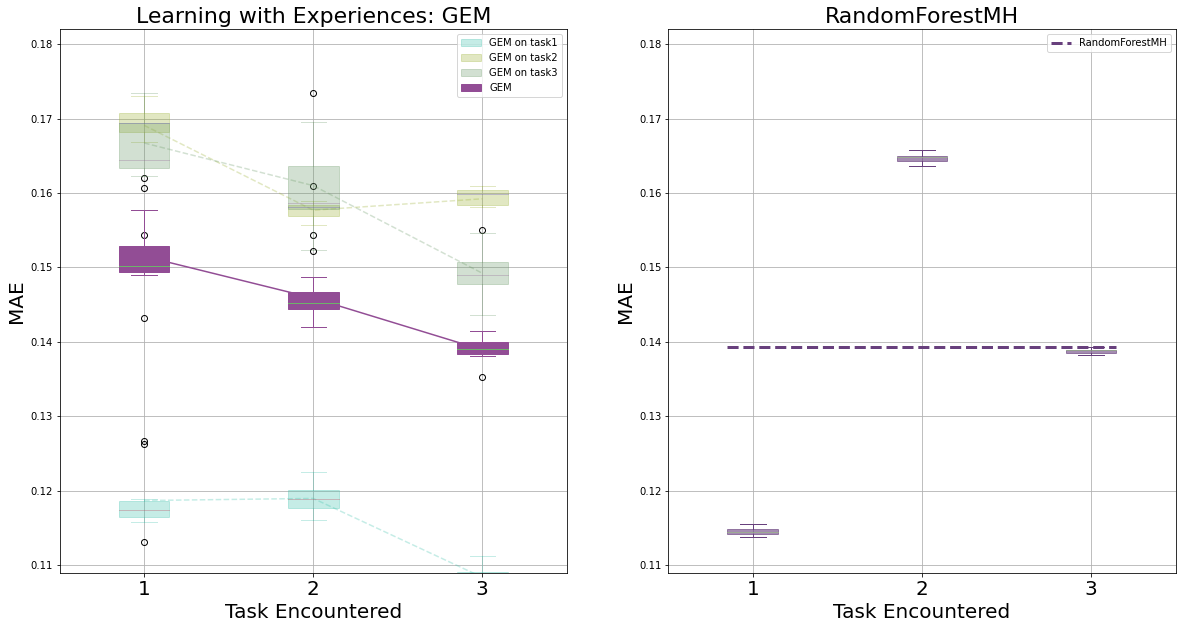

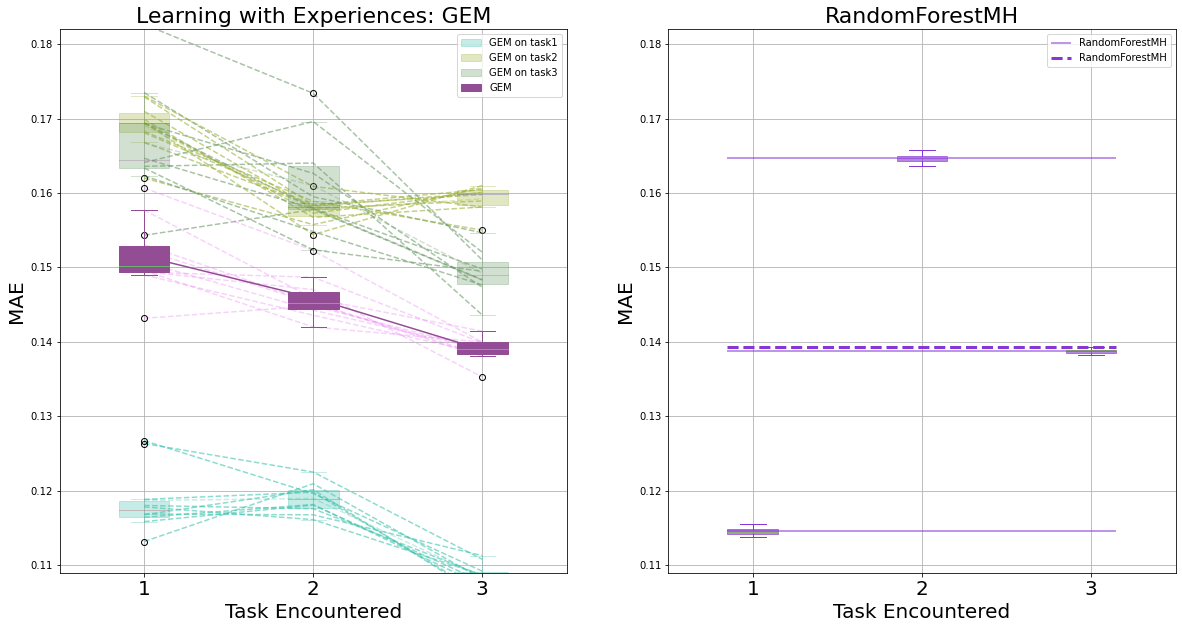

RandomForestMH RandomForest


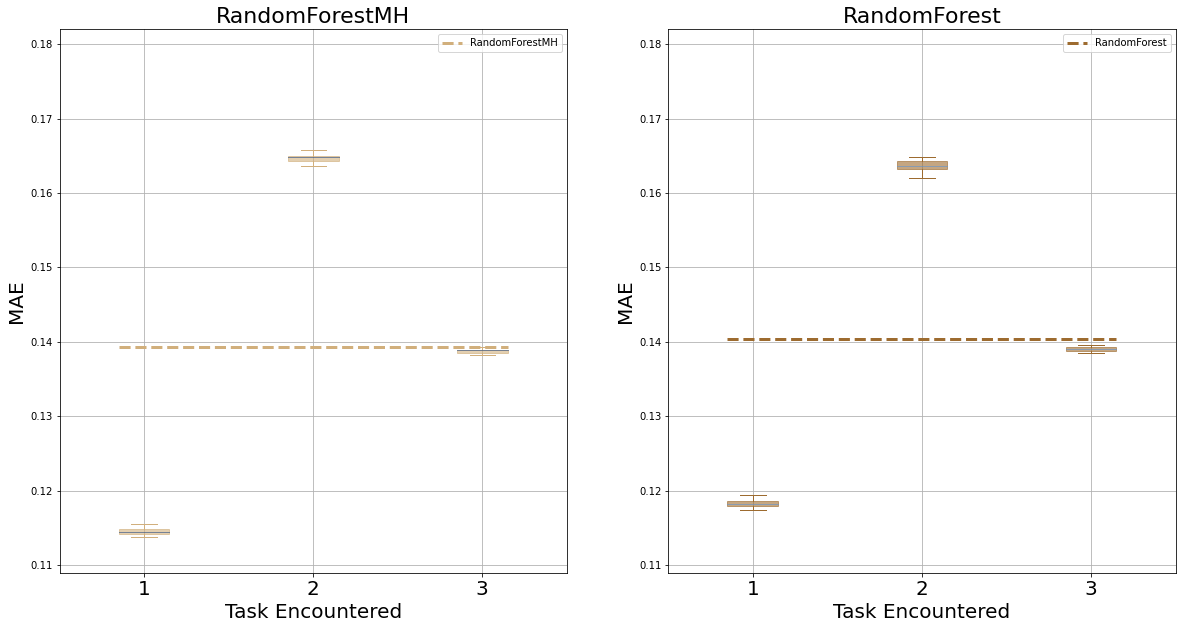

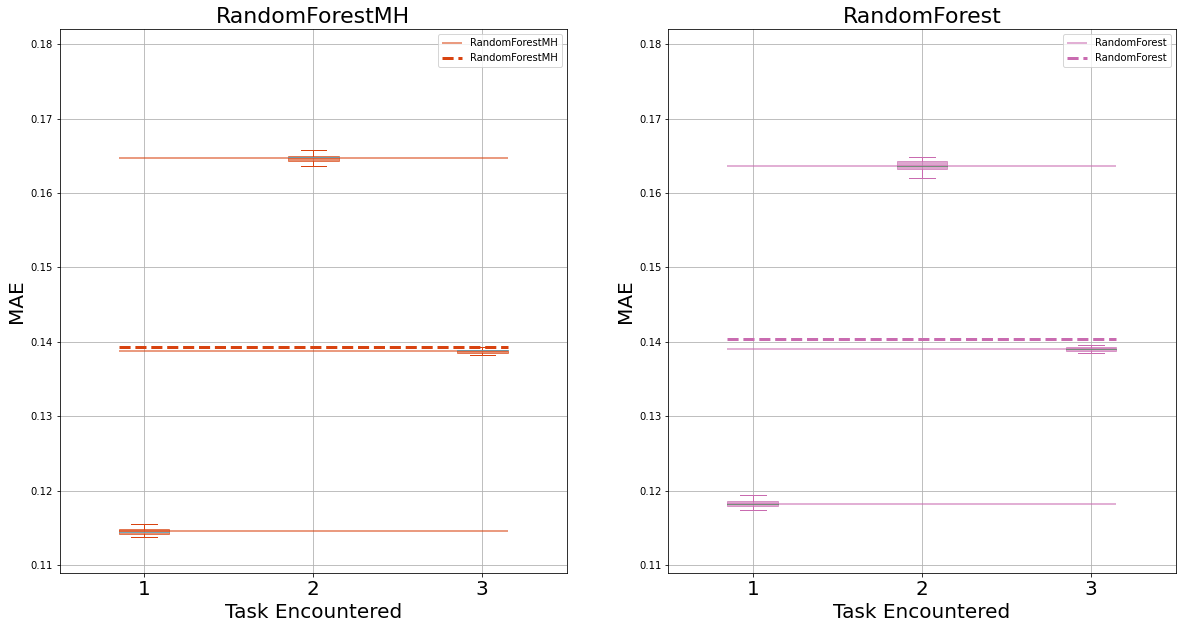

RandomForest Replay


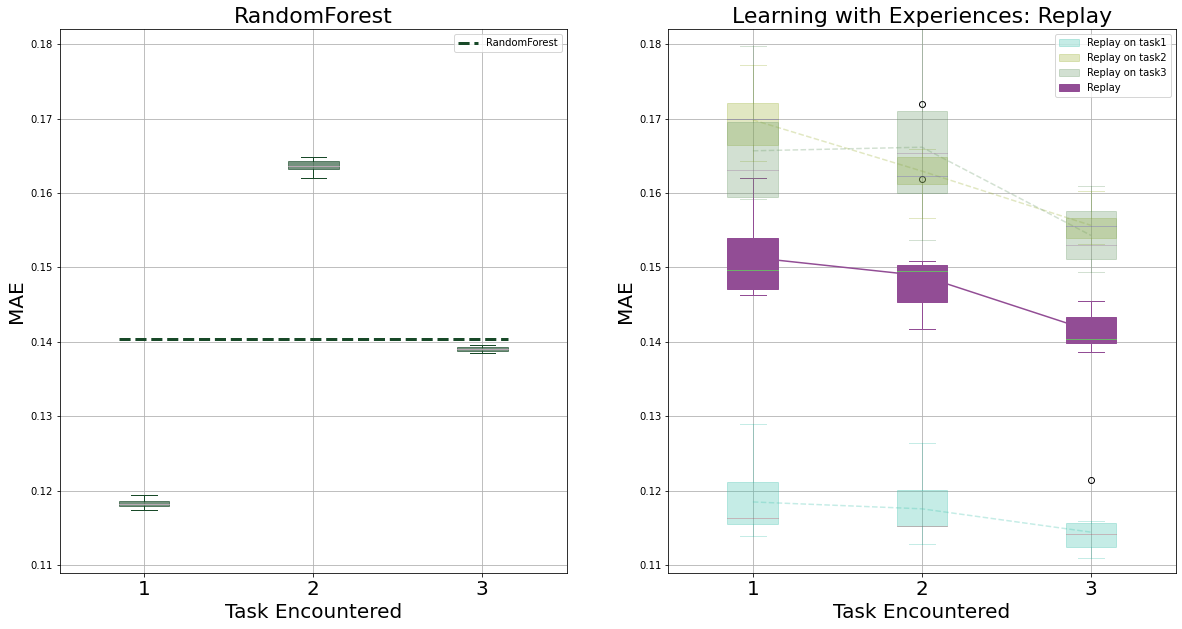

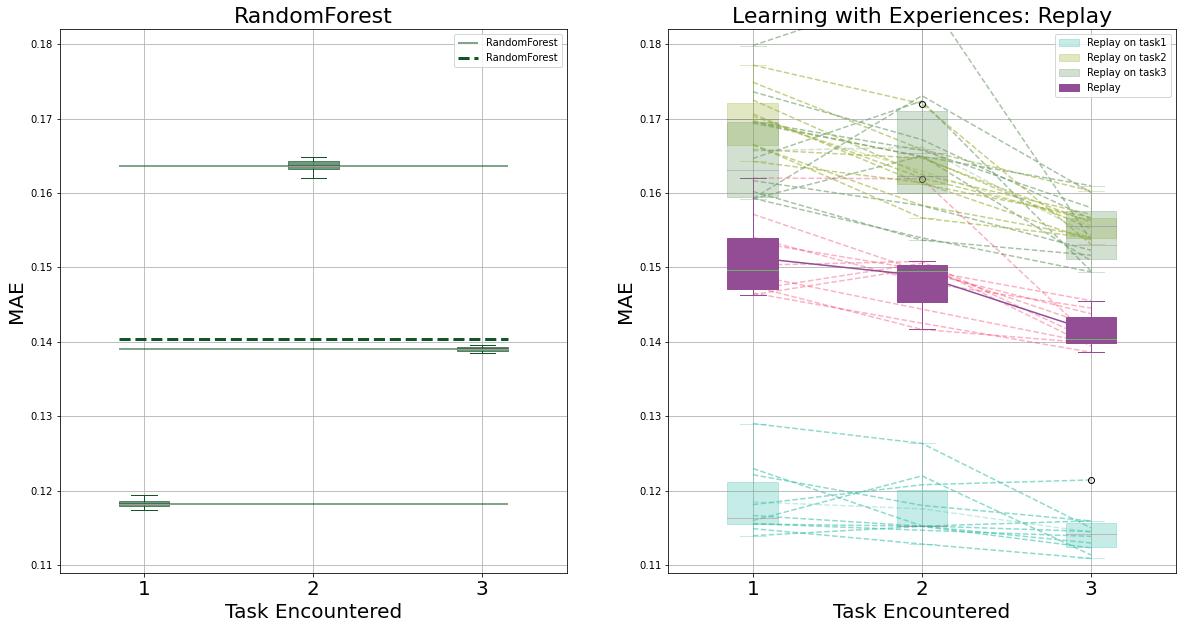

Replay EWC


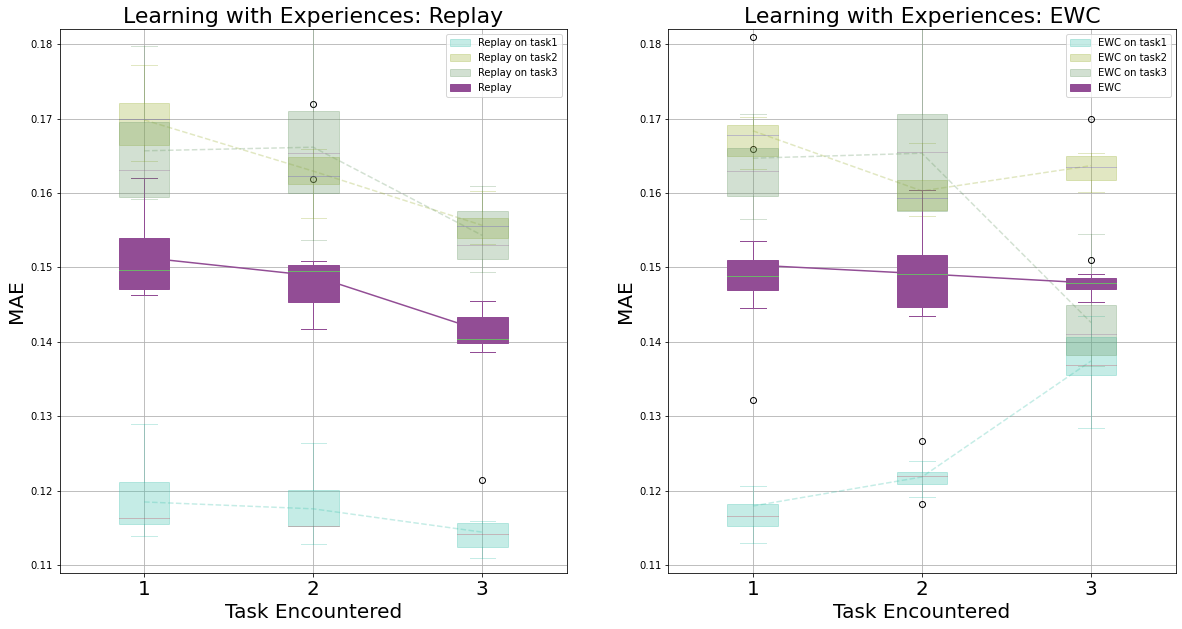

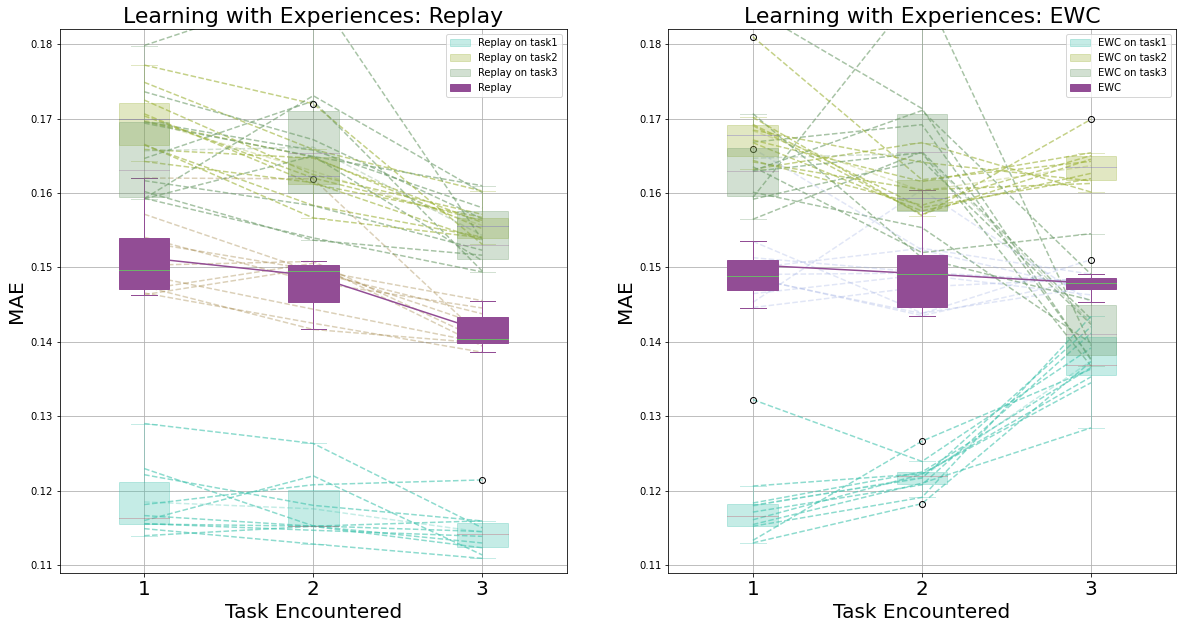

EWC SynapticIntelligence


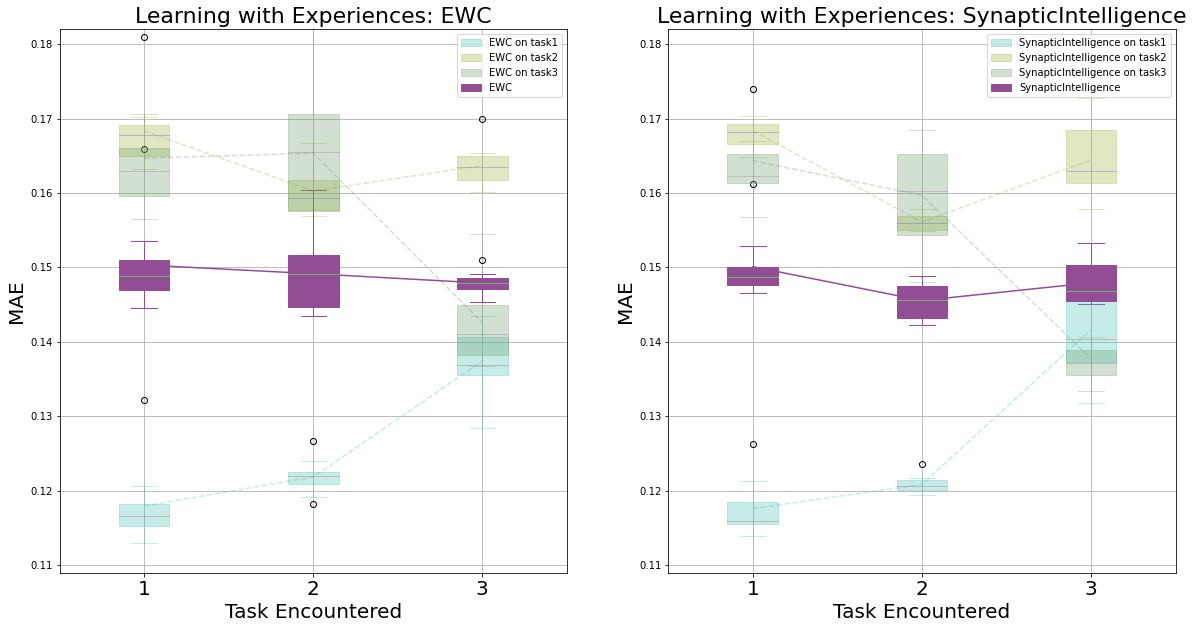

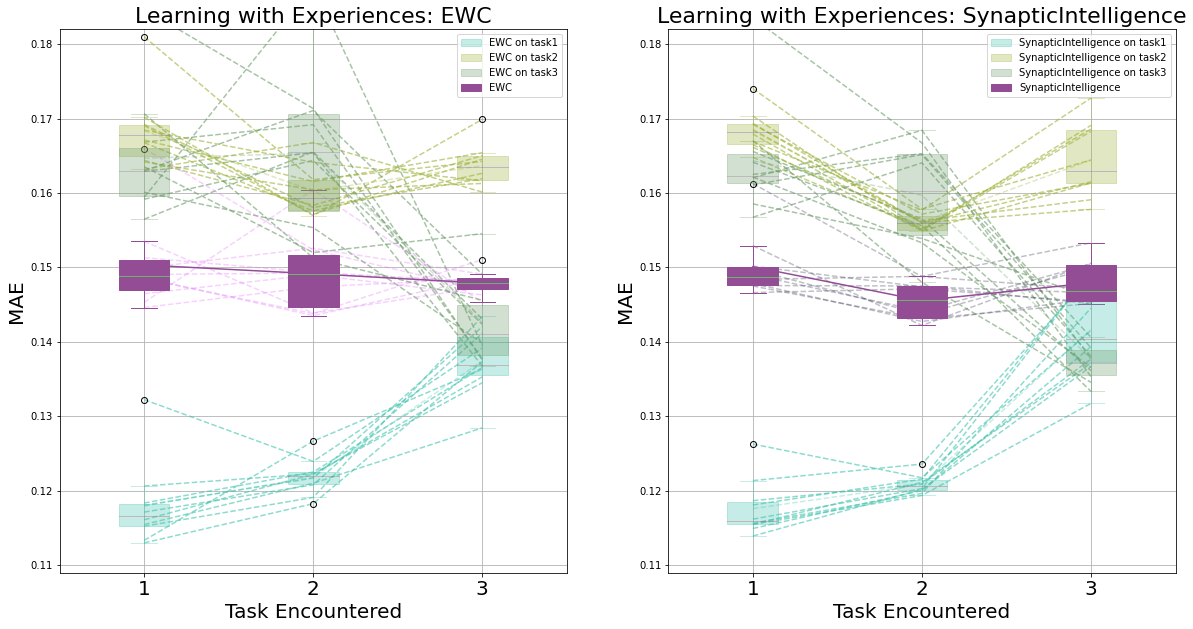

SynapticIntelligence Joint


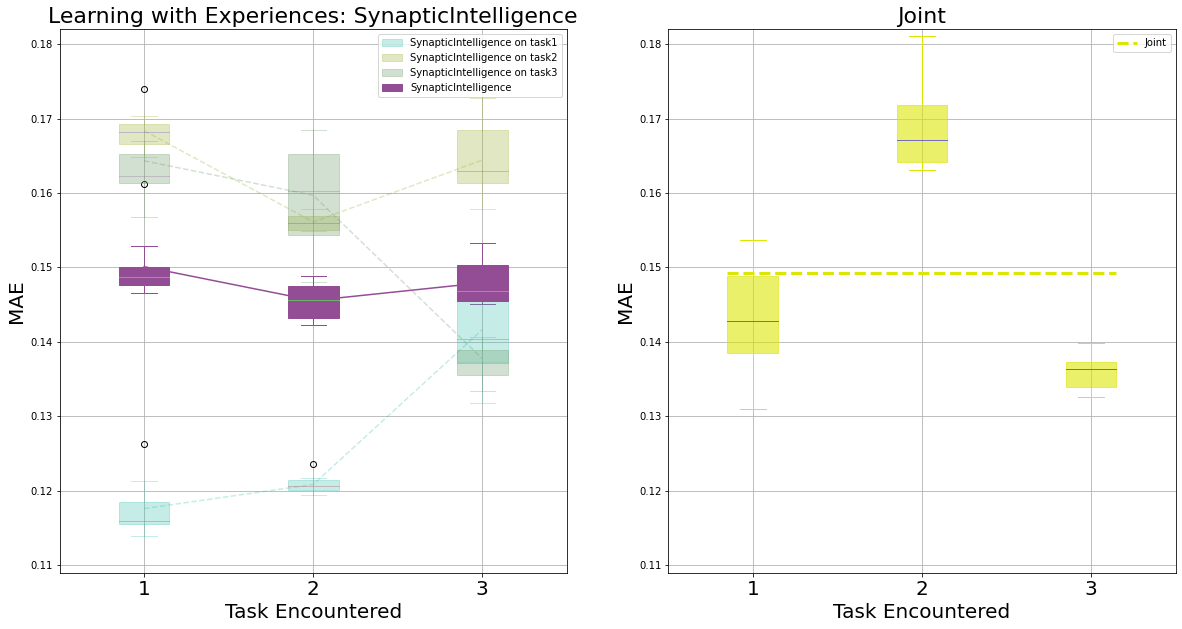

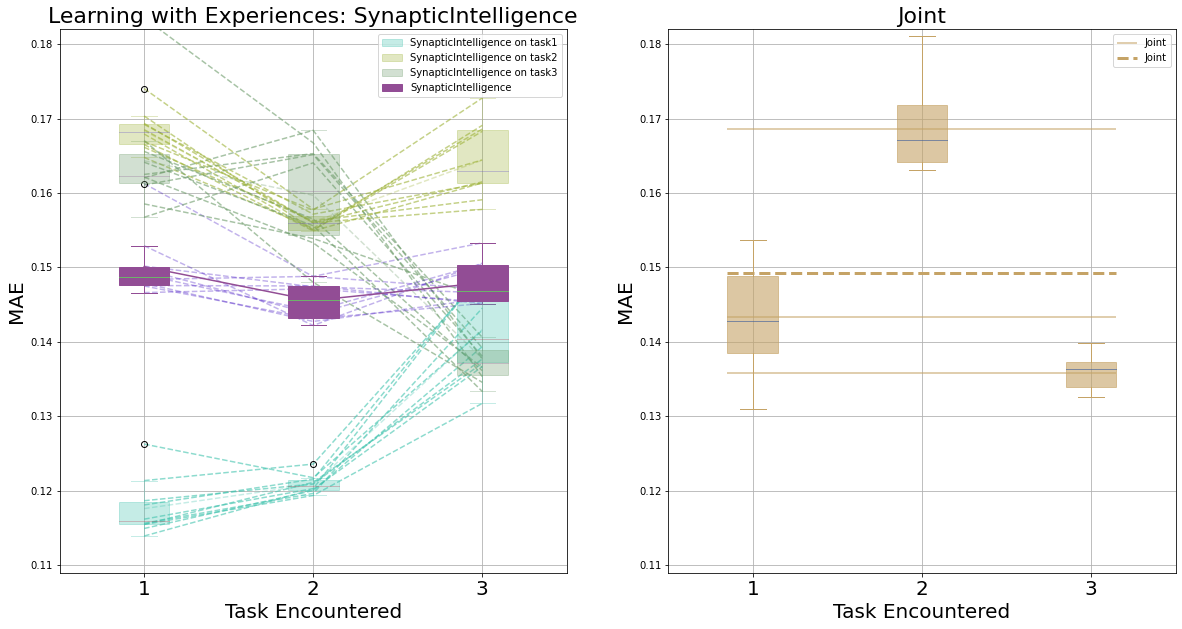

Joint GDumb


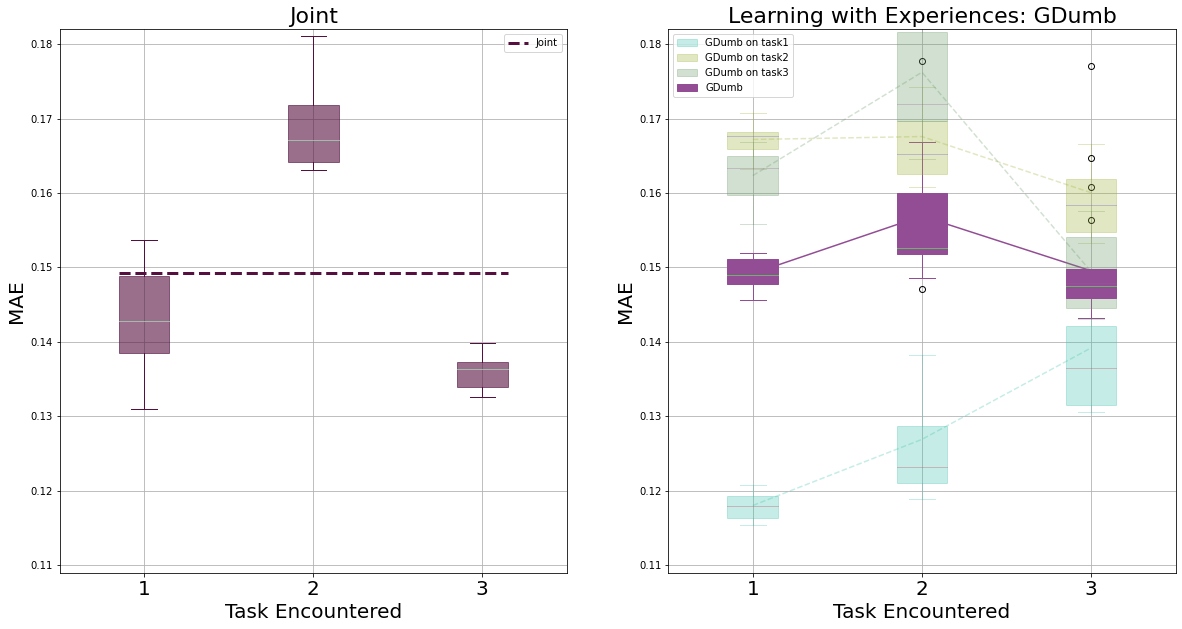

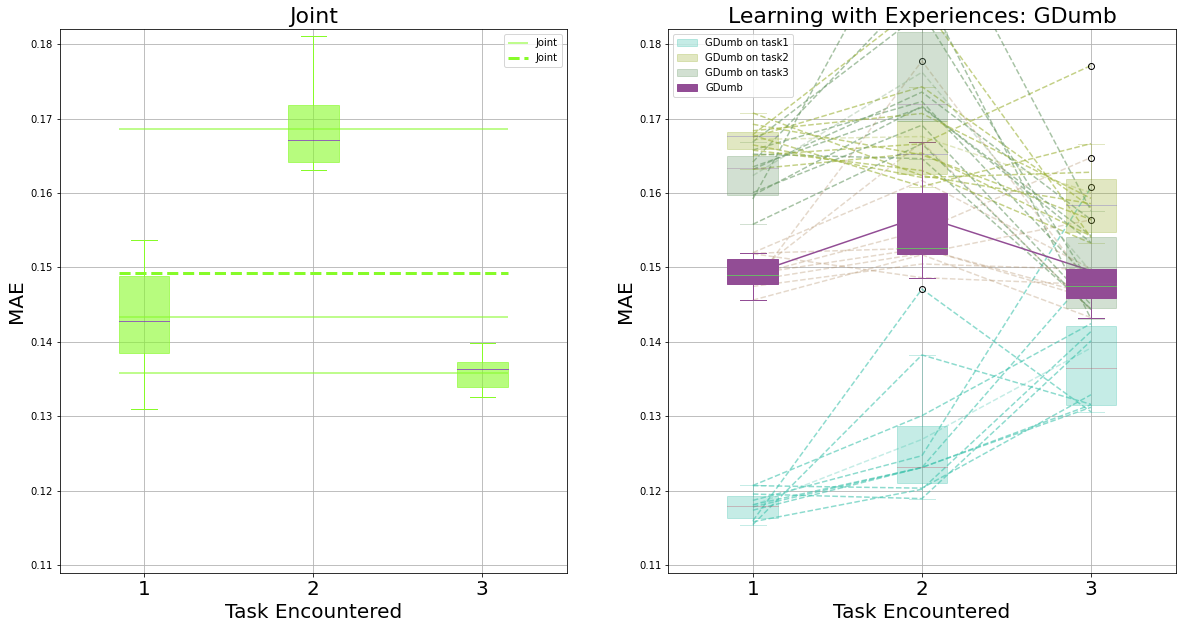

GDumb Cumulative


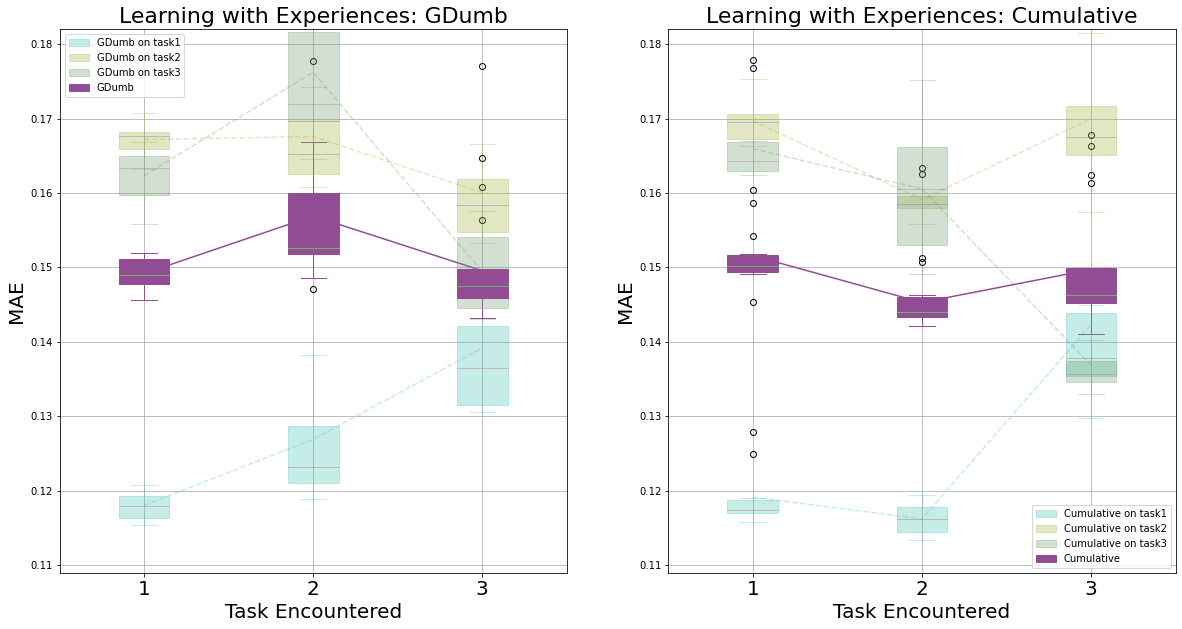

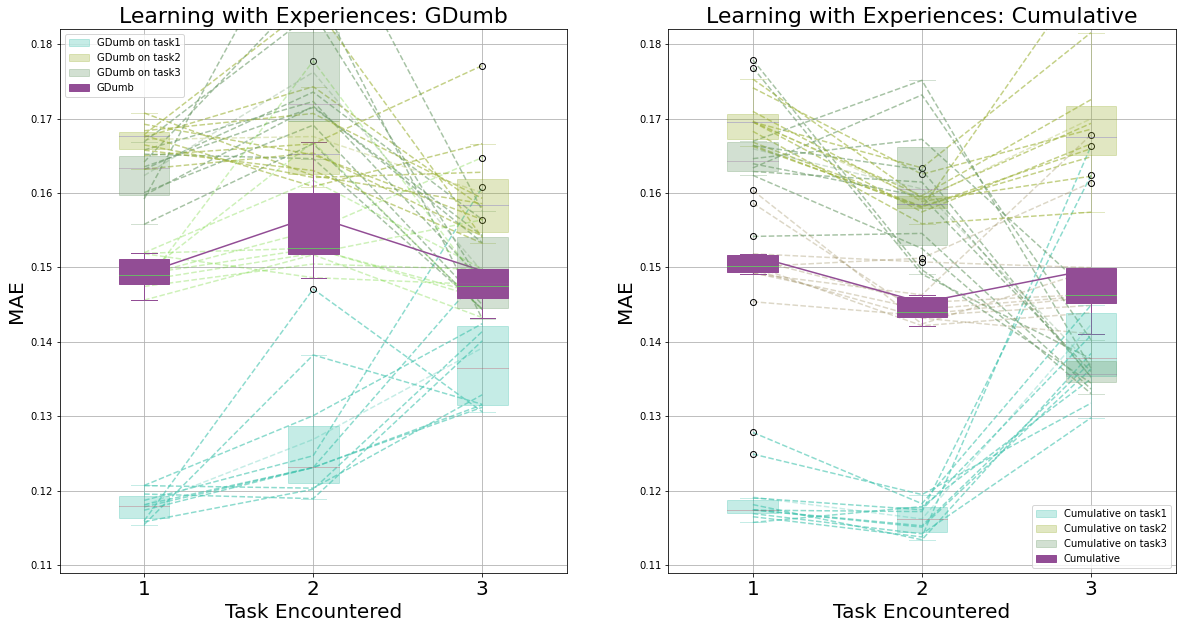

Cumulative LinearModelsMH


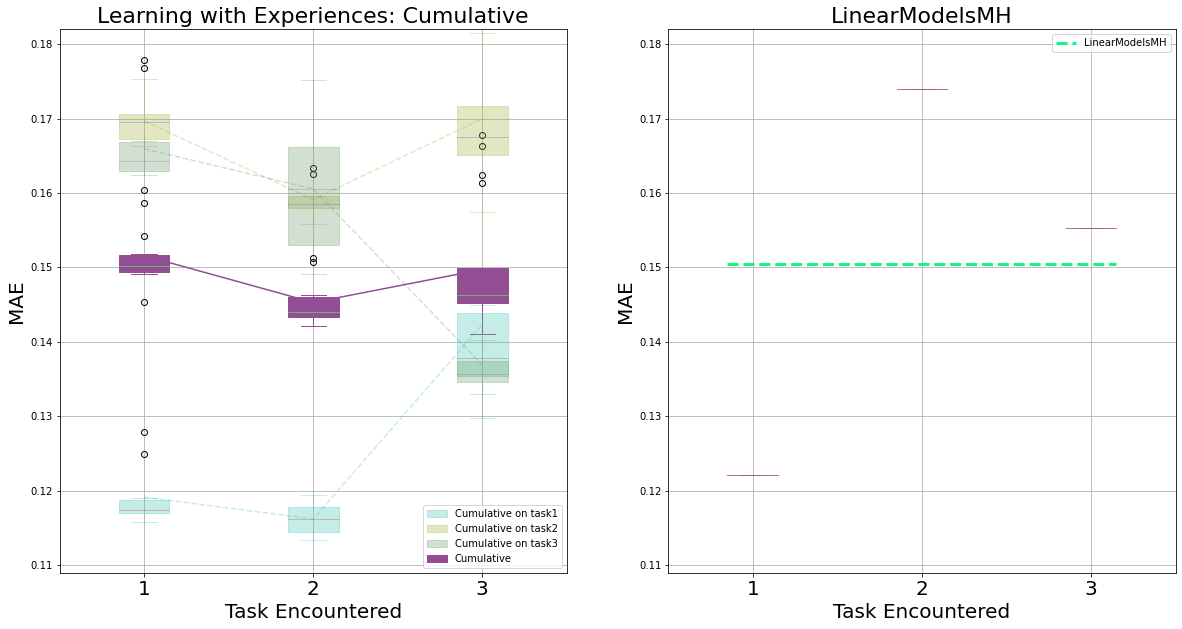

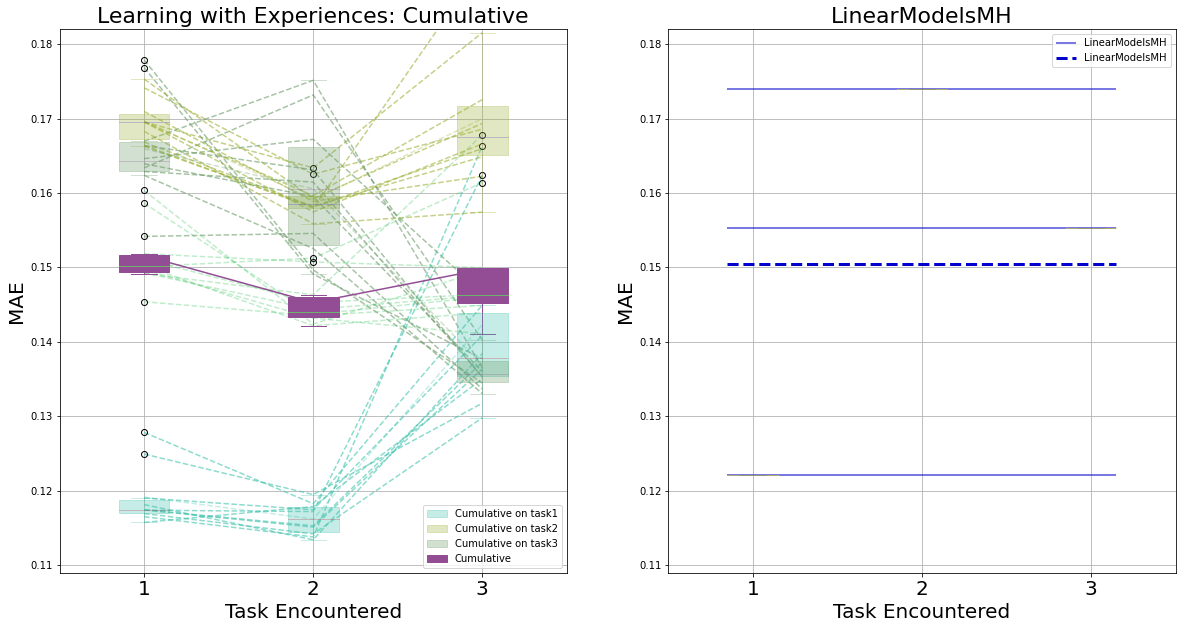

LinearModelsMH Naive


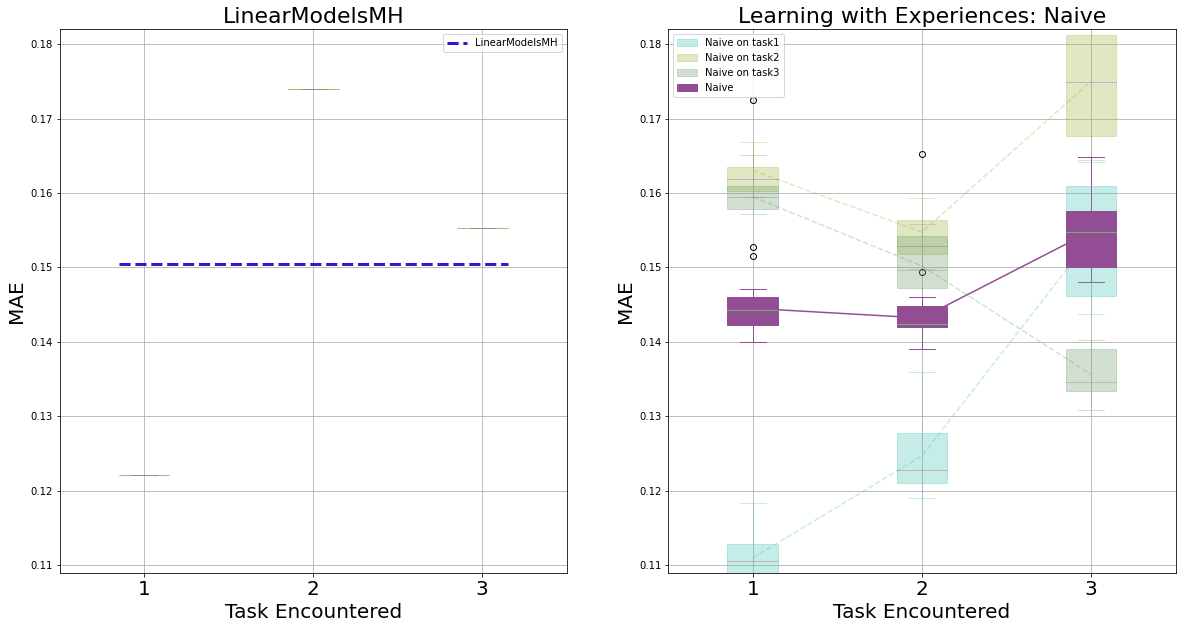

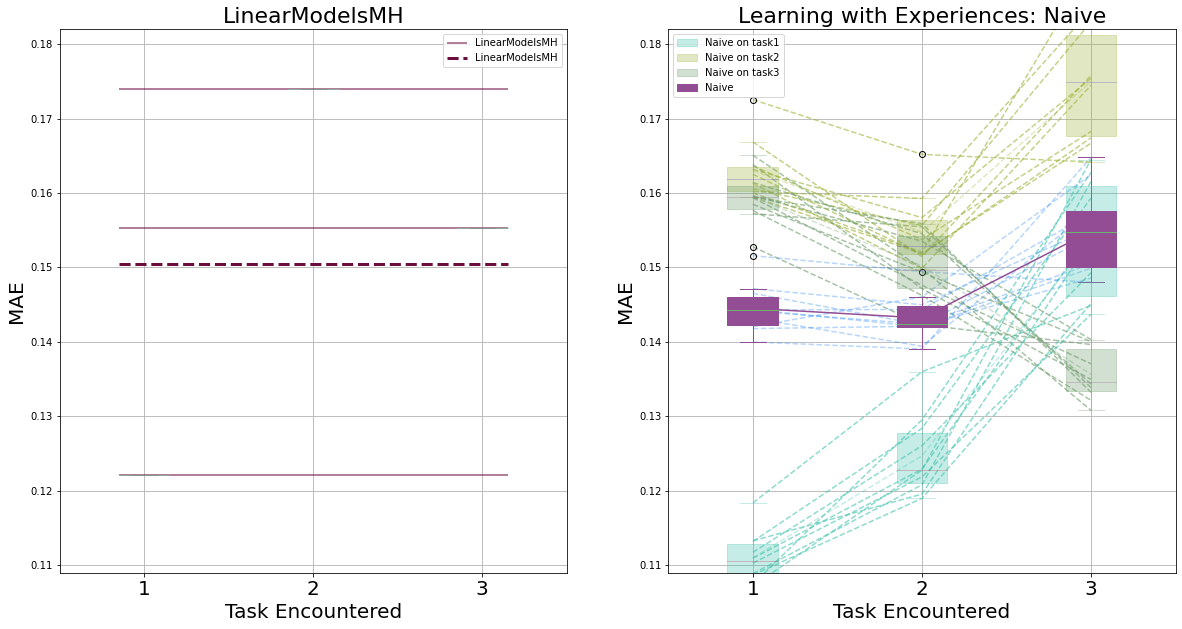

Naive LinearModel


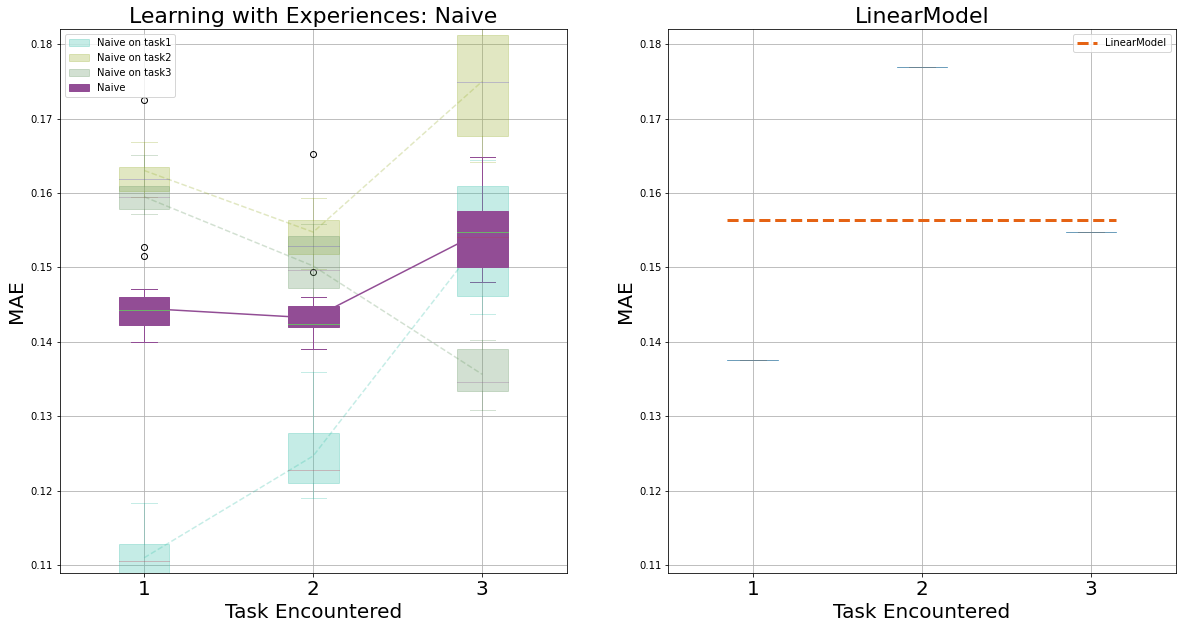

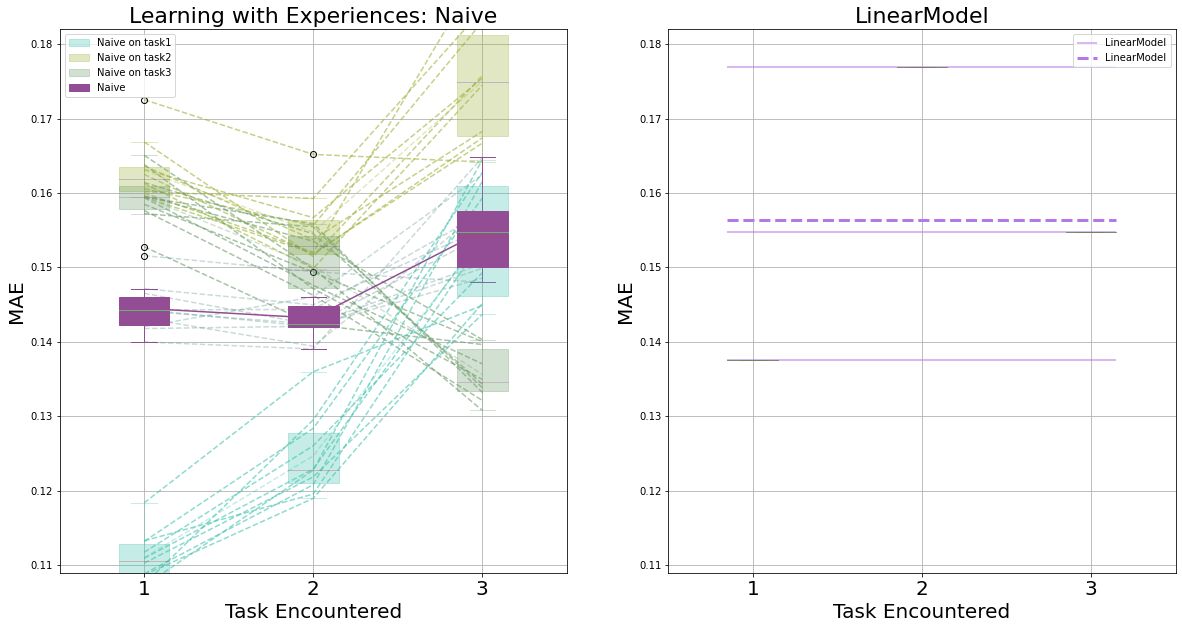

LinearModel LFL


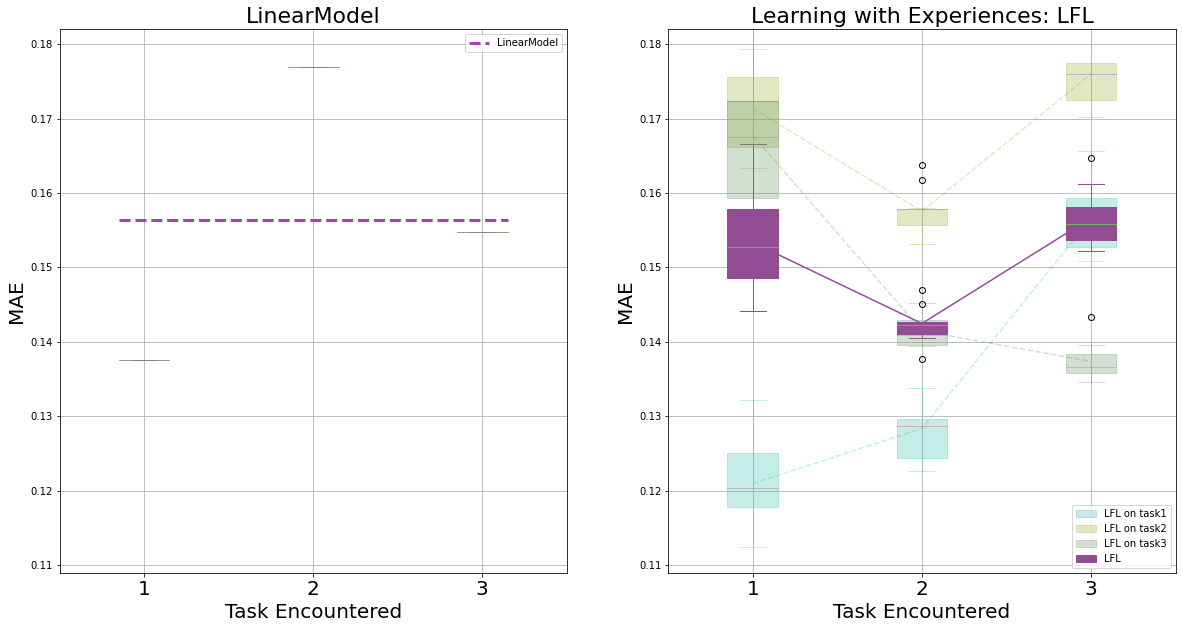

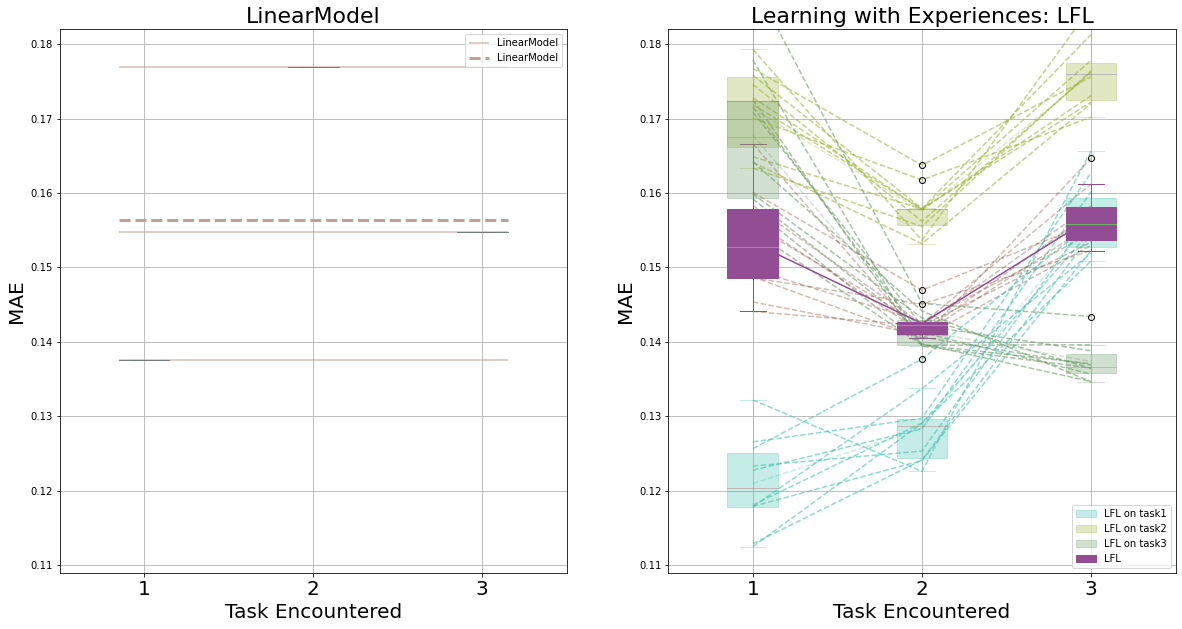

In [80]:
compare_strategies = list(zip(*best_s))[0]

for strategy1,strategy2 in zip(compare_strategies[:-1],compare_strategies[1:]):
    
    print(strategy1,strategy2)
    for dst in [False,True]:
        plt.figure(figsize=(20,10))
        if strategy1 in MONO_epoch_learners_NAMES:

            plt.subplot(1,2,1)
            plots_single_metric_box(losses=np.array(all_losses[strategy1]),
                                 strategy_name=strategy1,
                                titl=strategy1,
                                 main_color=np.random.rand(4),
                                 metric_name="MAE",
                                 task_colors=const_task_colors,
                                 draw_single_tasks=dst,
                                 line_style='--')
        else:
            plt.subplot(1,2,1)
            plots_for_many_tasks_box(losses=np.array(all_losses[strategy1]),
                             titl="Learning with Experiences: " +strategy1,
                             strategy_name=strategy1,
                             main_color=np.random.rand(4),
                             metric_name="MAE",
                             task_colors=const_task_colors,
                             draw_single_tasks=dst,
                             line_style='--')
        plt.ylim(.109,.182)
        if strategy2 in MONO_epoch_learners_NAMES:
            plt.subplot(1,2,2)
            plots_single_metric_box(losses=np.array(all_losses[strategy2]),
                                 titl=strategy2,
                                 strategy_name=strategy2,
                                 main_color=np.random.rand(4),
                                 task_colors=const_task_colors,
                                 metric_name="MAE",
                                 draw_single_tasks=dst,
                                 line_style='--')
        else:
            plt.subplot(1,2,2)
            plots_for_many_tasks_box(losses=np.array(all_losses[strategy2]),
                             titl="Learning with Experiences: " +strategy2,
                             strategy_name=strategy2,
                             main_color=np.random.rand(4),
                             task_colors=const_task_colors,
                             metric_name="MAE",
                             draw_single_tasks=dst,
                             line_style='--')
        plt.ylim(.109,.182)
        plt.show()

In [81]:
all_losses
#first element of each list is the score of the first test task after the training on the first task and so on

{'RandomForest': [array([0.11863575, 0.16439857, 0.13871491]),
  array([0.11804307, 0.16395429, 0.1392774 ]),
  array([0.11749937, 0.16342902, 0.13901019]),
  array([0.11851306, 0.16381967, 0.13935381]),
  array([0.11946311, 0.16323295, 0.138885  ]),
  array([0.11872724, 0.16468389, 0.13849331]),
  array([0.11791489, 0.16206514, 0.13964018]),
  array([0.11802349, 0.1647972 , 0.13872189]),
  array([0.11744997, 0.16248659, 0.13898029]),
  array([0.11864932, 0.16348228, 0.13956895])],
 'RandomForestMH': [array([0.11455327, 0.16564028, 0.1385757 ]),
  array([0.11487335, 0.16387842, 0.1384707 ]),
  array([0.11496686, 0.16488936, 0.13838014]),
  array([0.1143292 , 0.16488669, 0.13898647]),
  array([0.11375563, 0.16414439, 0.13891786]),
  array([0.11558839, 0.16466169, 0.13824632]),
  array([0.11439662, 0.16576769, 0.1392726 ]),
  array([0.11386923, 0.16499792, 0.13893562]),
  array([0.11555457, 0.16482622, 0.13895093]),
  array([0.11411203, 0.16368858, 0.13901722])],
 'LinearModel': [array([